<a href="https://colab.research.google.com/github/Harif19/Phonepe-Project/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%cd /content
!mkdir project_files
!ls -lh


/content
total 8.0K
drwxr-xr-x 2 root root 4.0K Oct  6 18:39 project_files
drwxr-xr-x 1 root root 4.0K Oct  3 13:36 sample_data


In [4]:
!git clone https://github.com/PhonePe/pulse.git


Cloning into 'pulse'...
remote: Enumerating objects: 17904, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 17904 (delta 19), reused 17 (delta 17), pack-reused 17855 (from 2)
Receiving objects: 100% (17904/17904), 26.13 MiB | 25.36 MiB/s, done.
Resolving deltas: 100% (8723/8723), done.


In [5]:
with open("/content/project_files/data_extraction.py", "w") as f:
    f.write("""
import os, json, sqlite3, glob, pandas as pd

def find_repo_path(base_path=None):
    if base_path and os.path.exists(base_path):
        return base_path
    fallback = './pulse/data/aggregated/transaction/country/india/state'
    if os.path.exists(fallback):
        return fallback
    raise FileNotFoundError(f"Could not find PhonePe pulse data at {base_path or fallback}. Please clone the repo.")

def build_sqlite_db(base_path=None, db_path=':memory:', verbose=True):
    repo_path = find_repo_path(base_path)
    conn = sqlite3.connect(db_path)

    # Helper loader
    def load_json_files(glob_pattern):
        rows = []
        for fp in glob.glob(glob_pattern, recursive=True):
            try:
                with open(fp, 'r') as f:
                    data = json.load(f)
                if isinstance(data, dict) and 'data' in data and isinstance(data['data'], list):
                    for item in data['data']:
                        rows.append(item)
                elif isinstance(data, list):
                    rows.extend(data)
            except Exception as e:
                if verbose: print('skip', fp, e)
        if rows:
            return pd.json_normalize(rows, sep='_')
        return pd.DataFrame()

    tx_df = load_json_files(os.path.join(repo_path, '**', '*.json'))
    if not tx_df.empty:
        tx_df.to_sql('aggregated_transaction', conn, if_exists='replace', index=False)
        if verbose: print('Wrote aggregated_transaction:', tx_df.shape)

    # Placeholder tables
    conn.execute('CREATE TABLE IF NOT EXISTS map_user (state TEXT, year INTEGER, quarter INTEGER, registeredUsers INTEGER, appOpens INTEGER, device_brand TEXT)')
    conn.execute('CREATE TABLE IF NOT EXISTS aggregated_insurance (state TEXT, year INTEGER, quarter INTEGER, insuranceValue REAL, insuranceCount INTEGER)')
    conn.commit()
    return conn

if __name__ == "__main__":
    conn = build_sqlite_db()
    print("Database built")
""")


In [6]:
import sys
sys.path.append("/content/project_files")

import data_extraction

db_path = "/content/project_files/phonepe_pulse.db"
conn = data_extraction.build_sqlite_db(
    base_path="./pulse/data/aggregated/transaction/country/india/state",
    db_path=db_path,
    verbose=True
)

cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print("Tables:", cur.fetchall())



Tables: [('map_user',), ('aggregated_insurance',)]


In [7]:
import os, json, sqlite3, glob, pandas as pd

def build_sqlite_db(base_path="/content/pulse/data", db_path="phonepe_pulse.db", verbose=True):
    conn = sqlite3.connect(db_path)

    # Mapping of folder -> table name
    folder_table_map = {
        "aggregated/transaction": "aggregated_transaction",
        "aggregated/user": "aggregated_user",
        "aggregated/insurance": "aggregated_insurance",
        "map/transaction": "map_transaction",
        "map/user": "map_user",
        "map/insurance": "map_insurance",
        "top/transaction": "top_transaction",
        "top/user": "top_user",
        "top/insurance": "top_insurance",
    }

    for folder, table in folder_table_map.items():
        folder_path = os.path.join(base_path, folder, "country", "india")
        if not os.path.exists(folder_path):
            if verbose:
                print(f"Skipping {folder_path}, not found")
            continue

        all_files = glob.glob(os.path.join(folder_path, "**", "*.json"), recursive=True)
        rows = []
        for file in all_files:
            try:
                with open(file, "r") as f:
                    data = json.load(f)

                # Each JSON has "data" -> "transactionData"/"usersByDevice"/etc.
                if "data" in data and isinstance(data["data"], list):
                    for entry in data["data"]:
                        rows.append(entry)
            except Exception as e:
                if verbose:
                    print("Error parsing", file, e)

        if rows:
            df = pd.json_normalize(rows, sep="_")
            df.to_sql(table, conn, if_exists="replace", index=False)
            if verbose:
                print(f"Loaded {len(df)} rows into {table}")
        else:
            if verbose:
                print(f"No rows for {table}")

    return conn

if __name__ == "__main__":
    conn = build_sqlite_db()
    print("Database built with tables:")
    print(pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", conn))


No rows for aggregated_transaction
No rows for aggregated_user
No rows for aggregated_insurance
Skipping /content/pulse/data/map/transaction/country/india, not found
Skipping /content/pulse/data/map/user/country/india, not found
No rows for map_insurance
No rows for top_transaction
No rows for top_user
No rows for top_insurance
Database built with tables:
Empty DataFrame
Columns: [name]
Index: []


In [8]:
import sqlite3

# Path to your DB
db_path = "/content/project_files/phonepe_pulse.db"

# Connect
conn = sqlite3.connect(db_path)

# Fetch all table names
tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

print("Tables in the database:")
for t in tables:
    print("-", t[0])

# Optional: check how many rows are in each table
print("\nRow counts:")
for t in tables:
    count = conn.execute(f"SELECT COUNT(*) FROM {t[0]}").fetchone()[0]
    print(f"{t[0]} : {count} rows")


Tables in the database:
- map_user
- aggregated_insurance

Row counts:
map_user : 0 rows
aggregated_insurance : 0 rows


In [9]:
import json

# Pick one aggregated transaction JSON
sample_file = "/content/pulse/data/aggregated/transaction/country/india/state/karnataka/2022/1.json"

with open(sample_file, "r") as f:
    data = json.load(f)

print(json.dumps(data, indent=2)[:1000])  # show first part


{
  "success": true,
  "code": "SUCCESS",
  "data": {
    "from": 1640975400000,
    "to": 1648405800000,
    "transactionData": [
      {
        "name": "Merchant payments",
        "paymentInstruments": [
          {
            "type": "TOTAL",
            "count": 588543313,
            "amount": 278109650949.8691
          }
        ]
      },
      {
        "name": "Peer-to-peer payments",
        "paymentInstruments": [
          {
            "type": "TOTAL",
            "count": 389491586,
            "amount": 1243199329198.8584
          }
        ]
      },
      {
        "name": "Recharge & bill payments",
        "paymentInstruments": [
          {
            "type": "TOTAL",
            "count": 78206453,
            "amount": 43891305256.63388
          }
        ]
      },
      {
        "name": "Financial Services",
        "paymentInstruments": [
          {
            "type": "TOTAL",
            "count": 384922,
            "amount": 624857963.437548
        

In [10]:
import os, json, sqlite3, glob, pandas as pd

def parse_aggregated_transaction(base_path, conn):
    folder = os.path.join(base_path, "aggregated/transaction/country/india/state")
    files = glob.glob(os.path.join(folder, "*/*/*.json"))  # state/year/quarter.json

    rows = []
    for file in files:
        parts = file.split("/")
        state = parts[-3]   # state name
        year = int(parts[-2])
        quarter = int(parts[-1].replace(".json", ""))

        with open(file, "r") as f:
            data = json.load(f)

        if "data" in data and "transactionData" in data["data"]:
            for entry in data["data"]["transactionData"]:
                name = entry["name"]
                for pi in entry["paymentInstruments"]:
                    rows.append({
                        "state": state,
                        "year": year,
                        "quarter": quarter,
                        "name": name,
                        "type": pi["type"],
                        "count": pi["count"],
                        "amount": pi["amount"]
                    })

    df = pd.DataFrame(rows)
    df.to_sql("aggregated_transaction", conn, if_exists="replace", index=False)
    print("aggregated_transaction:", len(df), "rows loaded")

def build_sqlite_db(base_path="/content/pulse/data", db_path="phonepe_pulse.db"):
    conn = sqlite3.connect(db_path)
    parse_aggregated_transaction(base_path, conn)
    return conn

if __name__ == "__main__":
    conn = build_sqlite_db()
    print("Done.")


aggregated_transaction: 5034 rows loaded
Done.


In [11]:
def parse_aggregated_user(base_path, conn):
    folder = os.path.join(base_path, "aggregated/user/country/india/state")
    files = glob.glob(os.path.join(folder, "*/*/*.json"))
    rows = []
    for file in files:
        state, year, quarter = file.split("/")[-3], int(file.split("/")[-2]), int(file.split("/")[-1].replace(".json",""))
        with open(file, "r") as f:
            data = json.load(f)
        if "usersByDevice" in data["data"] and data["data"]["usersByDevice"] is not None:
            for entry in data["data"]["usersByDevice"]:
                rows.append([state, year, quarter, entry.get("brand"), entry.get("count"), entry.get("percentage")])
    if rows:
        df = pd.DataFrame(rows, columns=["state","year","quarter","brand","count","percentage"])
        df.to_sql("aggregated_user", conn, if_exists="replace", index=False)
        print("aggregated_user:", len(df))
    else:
        print("aggregated_user: no rows")


In [12]:
"""
Extract Aggregated Transaction JSON files into SQLite
Table: aggregated_transaction
"""

import os, json, sqlite3, glob, pandas as pd

def parse_aggregated_transaction(base_path, conn):
    folder = os.path.join(base_path, "aggregated/transaction/country/india/state")
    files = glob.glob(os.path.join(folder, "*/*/*.json"))
    rows = []

    for file in files:
        state = file.split("/")[-3]
        year = int(file.split("/")[-2])
        quarter = int(file.split("/")[-1].replace(".json",""))

        with open(file, "r") as f:
            data = json.load(f)

        if "data" in data and "transactionData" in data["data"] and data["data"]["transactionData"] is not None:
            for entry in data["data"]["transactionData"]:
                category = entry.get("name")
                for pi in entry.get("paymentInstruments", []):
                    rows.append([
                        state, year, quarter, category,
                        pi.get("type"), pi.get("count"), pi.get("amount")
                    ])

    if rows:
        df = pd.DataFrame(rows, columns=["state","year","quarter","category","type","count","amount"])
        df.to_sql("aggregated_transaction", conn, if_exists="replace", index=False)
        print("✅ aggregated_transaction loaded:", len(df), "rows")
    else:
        print("⚠️ No data found for aggregated_transaction")

def build_db(db_path="/content/project_files/phonepe_pulse.db", base_path="/content/pulse/data"):
    conn = sqlite3.connect(db_path)
    parse_aggregated_transaction(base_path, conn)
    return conn

if __name__ == "__main__":
    conn = build_db()
    print("Tables in DB:", conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall())


✅ aggregated_transaction loaded: 5034 rows
Tables in DB: [('map_user',), ('aggregated_insurance',), ('aggregated_transaction',)]


In [13]:
# Save extract_aggregated_transaction.py into /content/project_files
file_path = "/content/project_files/extract_aggregated_transaction.py"

code = """
\"\"\"
Extract Aggregated Transaction JSON files into SQLite
Table: aggregated_transaction
\"\"\"

import os, json, sqlite3, glob, pandas as pd

def parse_aggregated_transaction(base_path, conn):
    folder = os.path.join(base_path, "aggregated/transaction/country/india/state")
    files = glob.glob(os.path.join(folder, "*/*/*.json"))
    rows = []

    for file in files:
        state = file.split("/")[-3]
        year = int(file.split("/")[-2])
        quarter = int(file.split("/")[-1].replace(".json",""))

        with open(file, "r") as f:
            data = json.load(f)

        if "data" in data and "transactionData" in data["data"] and data["data"]["transactionData"] is not None:
            for entry in data["data"]["transactionData"]:
                category = entry.get("name")
                for pi in entry.get("paymentInstruments", []):
                    rows.append([
                        state, year, quarter, category,
                        pi.get("type"), pi.get("count"), pi.get("amount")
                    ])

    if rows:
        df = pd.DataFrame(rows, columns=["state","year","quarter","category","type","count","amount"])
        df.to_sql("aggregated_transaction", conn, if_exists="replace", index=False)
        print("✅ aggregated_transaction loaded:", len(df), "rows")
    else:
        print("⚠️ No data found for aggregated_transaction")

def build_db(db_path="/content/project_files/phonepe_pulse.db", base_path="/content/pulse/data"):
    conn = sqlite3.connect(db_path)
    parse_aggregated_transaction(base_path, conn)
    return conn

if __name__ == "__main__":
    conn = build_db()
    print("Tables in DB:", conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall())
"""

with open(file_path, "w") as f:
    f.write(code)

print("✅ File saved at:", file_path)


✅ File saved at: /content/project_files/extract_aggregated_transaction.py


In [14]:
import os, json, sqlite3, glob, pandas as pd

def parse_aggregated_user(base_path, conn):
    folder = os.path.join(base_path, "aggregated/user/country/india/state")
    files = glob.glob(os.path.join(folder, "*/*/*.json"))
    rows = []

    for file in files:
        state = file.split("/")[-3]
        year = int(file.split("/")[-2])
        quarter = int(file.split("/")[-1].replace(".json",""))

        with open(file, "r") as f:
            data = json.load(f)

        if "data" in data and "usersByDevice" in data["data"] and data["data"]["usersByDevice"] is not None:
            for entry in data["data"]["usersByDevice"]:
                rows.append([
                    state, year, quarter,
                    entry.get("brand"), entry.get("count"), entry.get("percentage")
                ])

    if rows:
        df = pd.DataFrame(rows, columns=["state","year","quarter","brand","count","percentage"])
        df.to_sql("aggregated_user", conn, if_exists="replace", index=False)
        print("✅ aggregated_user loaded:", len(df), "rows")
    else:
        print("⚠️ No data found for aggregated_user")


In [15]:
import sqlite3

# DB path
db_path = "/content/project_files/phonepe_pulse.db"

# Connect to DB
conn = sqlite3.connect(db_path)

# Run parser
parse_aggregated_user("/content/pulse/data", conn)

# ✅ Verify tables
tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print("\nTables in DB:")
for t in tables:
    print("-", t[0])

# ✅ Row count
count = conn.execute("SELECT COUNT(*) FROM aggregated_user").fetchone()[0]
print("\nRow count in aggregated_user:", count)

# ✅ Preview first 5 rows
sample = conn.execute("SELECT * FROM aggregated_user LIMIT 5").fetchall()
print("\nSample rows:")
for row in sample:
    print(row)


✅ aggregated_user loaded: 6732 rows

Tables in DB:
- map_user
- aggregated_insurance
- aggregated_transaction
- aggregated_user

Row count in aggregated_user: 6732

Sample rows:
('arunachal-pradesh', 2018, 2, 'Xiaomi', 8058, 0.24505063406623484)
('arunachal-pradesh', 2018, 2, 'Samsung', 6633, 0.20171517197336009)
('arunachal-pradesh', 2018, 2, 'Vivo', 5591, 0.17002706565702644)
('arunachal-pradesh', 2018, 2, 'Oppo', 4204, 0.12784721588662834)
('arunachal-pradesh', 2018, 2, 'Realme', 1943, 0.0590882826992671)


In [16]:
def parse_aggregated_insurance(base_path, conn):
    folder = os.path.join(base_path, "aggregated/insurance/country/india/state")
    files = glob.glob(os.path.join(folder, "*/*/*.json"))
    rows = []

    for file in files:
        state = file.split("/")[-3]
        year = int(file.split("/")[-2])
        quarter = int(file.split("/")[-1].replace(".json",""))

        with open(file, "r") as f:
            data = json.load(f)

        if "data" in data:
            # Case 1: direct insuranceData
            if "insuranceData" in data["data"] and data["data"]["insuranceData"] is not None:
                for entry in data["data"]["insuranceData"]:
                    rows.append([state, year, quarter, entry.get("count"), entry.get("amount")])

            # Case 2: structured like transactionData
            elif "transactionData" in data["data"] and data["data"]["transactionData"] is not None:
                for entry in data["data"]["transactionData"]:
                    for pi in entry.get("paymentInstruments", []):
                        rows.append([state, year, quarter, pi.get("count"), pi.get("amount")])

    if rows:
        df = pd.DataFrame(rows, columns=["state","year","quarter","count","amount"])
        df.to_sql("aggregated_insurance", conn, if_exists="replace", index=False)
        print("✅ aggregated_insurance loaded:", len(df), "rows")
    else:
        print("⚠️ No data found for aggregated_insurance")


In [17]:

import json, glob, os

# Pick one folder to check, e.g. aggregated/transaction
folder = "/content/pulse/data/aggregated/transaction/country/india/state"

# Get one sample JSON file
sample_file = glob.glob(os.path.join(folder, "*/*/*.json"))[0]

print("📂 Sample file:", sample_file)

with open(sample_file, "r") as f:
    data = json.load(f)

print("\n🔑 Keys inside root JSON:")
print(list(data.keys()))

if "data" in data:
    print("\n🔑 Keys inside data:")
    print(list(data["data"].keys()))

    # Show some values for inspection
    for k,v in data["data"].items():
        if isinstance(v, list):
            print(f" - {k}: list with {len(v)} items")
        elif isinstance(v, dict):
            print(f" - {k}: dict with keys {list(v.keys())}")
        else:
            print(f" - {k}: {v}")


📂 Sample file: /content/pulse/data/aggregated/transaction/country/india/state/arunachal-pradesh/2023/2.json

🔑 Keys inside root JSON:
['success', 'code', 'data', 'responseTimestamp']

🔑 Keys inside data:
['from', 'to', 'transactionData']
 - from: 1680287400000
 - to: 1687890600000
 - transactionData: list with 5 items


In [18]:
import glob, os, json

base_path = "/content/pulse/data"

folders = {
    "aggregated_transaction": "aggregated/transaction/country/india/state",
    "aggregated_user": "aggregated/user/country/india/state",
    "aggregated_insurance": "aggregated/insurance/country/india/state",
    "map_transaction": "map/transaction/hover/country/india/state",
    "map_user": "map/user/hover/country/india/state",
    "map_insurance": "map/insurance/hover/country/india/state",
    "top_transaction": "top/transaction/country/india/state",
    "top_user": "top/user/country/india/state",
    "top_insurance": "top/insurance/country/india/state"
}

for name, folder in folders.items():
    files = glob.glob(os.path.join(base_path, folder, "*/*/*.json"))
    if not files:
        print(f"\n❌ No files found for {name}")
        continue
    sample_file = files[0]
    print(f"\n📂 {name} -> {sample_file}")
    with open(sample_file, "r") as f:
        data = json.load(f)

    print("Root keys:", list(data.keys()))
    if "data" in data:
        print("Data keys:", list(data["data"].keys()))
        for k,v in data["data"].items():
            if isinstance(v, list):
                print(f" - {k}: list with {len(v)} items")
            elif isinstance(v, dict):
                print(f" - {k}: dict with keys {list(v.keys())}")
            else:
                print(f" - {k}: {v}")



📂 aggregated_transaction -> /content/pulse/data/aggregated/transaction/country/india/state/arunachal-pradesh/2023/2.json
Root keys: ['success', 'code', 'data', 'responseTimestamp']
Data keys: ['from', 'to', 'transactionData']
 - from: 1680287400000
 - to: 1687890600000
 - transactionData: list with 5 items

📂 aggregated_user -> /content/pulse/data/aggregated/user/country/india/state/arunachal-pradesh/2023/2.json
Root keys: ['success', 'code', 'data', 'responseTimestamp']
Data keys: ['aggregated', 'usersByDevice']
 - aggregated: dict with keys ['registeredUsers', 'appOpens']
 - usersByDevice: None

📂 aggregated_insurance -> /content/pulse/data/aggregated/insurance/country/india/state/arunachal-pradesh/2023/2.json
Root keys: ['success', 'code', 'data', 'responseTimestamp']
Data keys: ['from', 'to', 'transactionData']
 - from: 1680287400000
 - to: 1687890600000
 - transactionData: list with 1 items

📂 map_transaction -> /content/pulse/data/map/transaction/hover/country/india/state/arunac

In [19]:
"""
Extract Aggregated Insurance JSON files into SQLite
Table: aggregated_insurance
"""

import os, json, sqlite3, glob, pandas as pd

def parse_aggregated_insurance(base_path, conn):
    folder = os.path.join(base_path, "aggregated/insurance/country/india/state")
    files = glob.glob(os.path.join(folder, "*/*/*.json"))
    rows = []

    for file in files:
        state = file.split("/")[-3]
        year = int(file.split("/")[-2])
        quarter = int(file.split("/")[-1].replace(".json",""))

        with open(file, "r") as f:
            data = json.load(f)

        if "data" in data and "transactionData" in data["data"] and data["data"]["transactionData"] is not None:
            for entry in data["data"]["transactionData"]:
                name = entry.get("name")
                for pi in entry.get("paymentInstruments", []):
                    rows.append([state, year, quarter, name, pi.get("count"), pi.get("amount")])

    if rows:
        df = pd.DataFrame(rows, columns=["state","year","quarter","category","count","amount"])
        df.to_sql("aggregated_insurance", conn, if_exists="replace", index=False)
        print("✅ aggregated_insurance loaded:", len(df), "rows")
    else:
        print("⚠️ No data found for aggregated_insurance")

def build_db(db_path="/content/project_files/phonepe_pulse.db", base_path="/content/pulse/data"):
    conn = sqlite3.connect(db_path)
    parse_aggregated_insurance(base_path, conn)
    return conn


In [20]:
"""
Extract Aggregated Insurance JSON files into SQLite
Table: aggregated_insurance
"""

import os, json, sqlite3, glob, pandas as pd

def parse_aggregated_insurance(base_path, conn):
    folder = os.path.join(base_path, "aggregated/insurance/country/india/state")
    files = glob.glob(os.path.join(folder, "*/*/*.json"))
    rows = []

    for file in files:
        state = file.split("/")[-3]
        year = int(file.split("/")[-2])
        quarter = int(file.split("/")[-1].replace(".json",""))

        with open(file, "r") as f:
            data = json.load(f)

        # ✅ Insurance JSON actually uses "transactionData"
        if "data" in data and "transactionData" in data["data"] and data["data"]["transactionData"] is not None:
            for entry in data["data"]["transactionData"]:
                category = entry.get("name")   # e.g., "Life Insurance"
                for pi in entry.get("paymentInstruments", []):
                    rows.append([
                        state, year, quarter, category,
                        pi.get("count"), pi.get("amount")
                    ])

    if rows:
        df = pd.DataFrame(rows, columns=["state","year","quarter","category","count","amount"])
        df.to_sql("aggregated_insurance", conn, if_exists="replace", index=False)
        print("✅ aggregated_insurance loaded:", len(df), "rows")
    else:
        print("⚠️ No data found for aggregated_insurance")

def build_db(db_path="/content/project_files/phonepe_pulse.db", base_path="/content/pulse/data"):
    conn = sqlite3.connect(db_path)
    parse_aggregated_insurance(base_path, conn)
    return conn

if __name__ == "__main__":
    conn = build_db()
    print("Tables in DB:", conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall())


✅ aggregated_insurance loaded: 682 rows
Tables in DB: [('map_user',), ('aggregated_transaction',), ('aggregated_user',), ('aggregated_insurance',)]


In [21]:
with open("/content/project_files/extract_aggregated_insurance.py", "w") as f:
    f.write(code)
print("✅ File saved: extract_aggregated_insurance.py")


✅ File saved: extract_aggregated_insurance.py


In [22]:
import sys
sys.path.append("/content/project_files")

import extract_aggregated_insurance as eai

conn = eai.build_db()
print("Row count:", conn.execute("SELECT COUNT(*) FROM aggregated_insurance").fetchone())
print("Sample rows:")
print(conn.execute("SELECT * FROM aggregated_insurance LIMIT 5").fetchall())


✅ aggregated_transaction loaded: 5034 rows
Row count: (682,)
Sample rows:
[('arunachal-pradesh', 2023, 2, 'Insurance', 696, 2095988.0), ('arunachal-pradesh', 2023, 4, 'Insurance', 809, 2105408.0), ('arunachal-pradesh', 2023, 3, 'Insurance', 718, 1904786.0), ('arunachal-pradesh', 2023, 1, 'Insurance', 606, 1747475.0), ('arunachal-pradesh', 2021, 2, 'Insurance', 204, 224928.0)]


In [23]:
"""
Extract Map Transaction JSON files into SQLite
Table: map_transaction
"""

import os, json, sqlite3, glob, pandas as pd

def parse_map_transaction(base_path, conn):
    folder = os.path.join(base_path, "map/transaction/hover/country/india/state")
    files = glob.glob(os.path.join(folder, "*/*/*.json"))
    rows = []

    for file in files:
        state = file.split("/")[-3]
        year = int(file.split("/")[-2])
        quarter = int(file.split("/")[-1].replace(".json",""))

        with open(file, "r") as f:
            data = json.load(f)

        if "data" in data and "hoverDataList" in data["data"] and data["data"]["hoverDataList"] is not None:
            for entry in data["data"]["hoverDataList"]:
                district = entry.get("name")
                for metric in entry.get("metric", []):
                    rows.append([
                        state, year, quarter, district,
                        metric.get("type"), metric.get("count"), metric.get("amount")
                    ])

    if rows:
        df = pd.DataFrame(rows, columns=["state","year","quarter","district","type","count","amount"])
        df.to_sql("map_transaction", conn, if_exists="replace", index=False)
        print("✅ map_transaction loaded:", len(df), "rows")
    else:
        print("⚠️ No data found for map_transaction")

def build_db(db_path="/content/project_files/phonepe_pulse.db", base_path="/content/pulse/data"):
    conn = sqlite3.connect(db_path)
    parse_map_transaction(base_path, conn)
    return conn

if __name__ == "__main__":
    conn = build_db()
    print("Tables in DB:", conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall())


✅ map_transaction loaded: 20604 rows
Tables in DB: [('map_user',), ('aggregated_user',), ('aggregated_insurance',), ('aggregated_transaction',), ('map_transaction',)]


In [24]:
with open("/content/project_files/extract_map_transaction.py", "w") as f:
    f.write(code)
print("✅ File saved: extract_map_transaction.py")


✅ File saved: extract_map_transaction.py


In [25]:
import sys
sys.path.append("/content/project_files")

import extract_map_transaction as emt

conn = emt.build_db()
print("Row count:", conn.execute("SELECT COUNT(*) FROM map_transaction").fetchone())
print("Sample rows:")
print(conn.execute("SELECT * FROM map_transaction LIMIT 5").fetchall())


✅ aggregated_transaction loaded: 5034 rows
Row count: (20604,)
Sample rows:
[('arunachal-pradesh', 2023, 2, 'lower dibang valley district', 'TOTAL', 320847, 641502543.0), ('arunachal-pradesh', 2023, 2, 'lower subansiri district', 'TOTAL', 341107, 689315626.0), ('arunachal-pradesh', 2023, 2, 'longding district', 'TOTAL', 130522, 285288333.0), ('arunachal-pradesh', 2023, 2, 'west siang district', 'TOTAL', 450143, 970914462.0), ('arunachal-pradesh', 2023, 2, 'kamle district', 'TOTAL', 55865, 106363865.0)]


In [26]:
"""
Extract Map User JSON files into SQLite
Table: map_user
"""

import os, json, sqlite3, glob, pandas as pd

def parse_map_user(base_path, conn):
    folder = os.path.join(base_path, "map/user/hover/country/india/state")
    files = glob.glob(os.path.join(folder, "*/*/*.json"))
    rows = []

    for file in files:
        state = file.split("/")[-3]
        year = int(file.split("/")[-2])
        quarter = int(file.split("/")[-1].replace(".json",""))

        with open(file, "r") as f:
            data = json.load(f)

        if "data" in data and "hoverData" in data["data"] and data["data"]["hoverData"] is not None:
            for district, values in data["data"]["hoverData"].items():
                rows.append([
                    state, year, quarter, district,
                    values.get("registeredUsers"), values.get("appOpens")
                ])

    if rows:
        df = pd.DataFrame(rows, columns=["state","year","quarter","district","registeredUsers","appOpens"])
        df.to_sql("map_user", conn, if_exists="replace", index=False)
        print("✅ map_user loaded:", len(df), "rows")
    else:
        print("⚠️ No data found for map_user")

def build_db(db_path="/content/project_files/phonepe_pulse.db", base_path="/content/pulse/data"):
    conn = sqlite3.connect(db_path)
    parse_map_user(base_path, conn)
    return conn

if __name__ == "__main__":
    conn = build_db()
    print("Tables in DB:", conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall())


✅ map_user loaded: 20608 rows
Tables in DB: [('aggregated_user',), ('aggregated_insurance',), ('map_transaction',), ('aggregated_transaction',), ('map_user',)]


In [27]:
with open("/content/project_files/extract_map_user.py", "w") as f:
    f.write(code)
print("✅ File saved: extract_map_user.py")


✅ File saved: extract_map_user.py


In [28]:
import sys
sys.path.append("/content/project_files")

import extract_map_user as emu

conn = emu.build_db()
print("Row count:", conn.execute("SELECT COUNT(*) FROM map_user").fetchone())
print("Sample rows:")
print(conn.execute("SELECT * FROM map_user LIMIT 5").fetchall())


✅ aggregated_transaction loaded: 5034 rows
Row count: (20608,)
Sample rows:
[('arunachal-pradesh', 2023, 2, 'lower subansiri district', 13816, 5009447), ('arunachal-pradesh', 2023, 2, 'tirap district', 12712, 3111463), ('arunachal-pradesh', 2023, 2, 'papum pare district', 141879, 8027014), ('arunachal-pradesh', 2023, 2, 'anjaw district', 4513, 1212448), ('arunachal-pradesh', 2023, 2, 'lower siang district', 6218, 2625653)]


In [29]:
"""
Extract Map Insurance JSON files into SQLite
Table: map_insurance
"""

import os, json, sqlite3, glob, pandas as pd

def parse_map_insurance(base_path, conn):
    folder = os.path.join(base_path, "map/insurance/hover/country/india/state")
    files = glob.glob(os.path.join(folder, "*/*/*.json"))
    rows = []

    for file in files:
        state = file.split("/")[-3]
        year = int(file.split("/")[-2])
        quarter = int(file.split("/")[-1].replace(".json",""))

        with open(file, "r") as f:
            data = json.load(f)

        if "data" in data and "hoverDataList" in data["data"] and data["data"]["hoverDataList"] is not None:
            for entry in data["data"]["hoverDataList"]:
                district = entry.get("name")
                for metric in entry.get("metric", []):
                    rows.append([
                        state, year, quarter, district,
                        metric.get("type"), metric.get("count"), metric.get("amount")
                    ])

    if rows:
        df = pd.DataFrame(rows, columns=["state","year","quarter","district","type","count","amount"])
        df.to_sql("map_insurance", conn, if_exists="replace", index=False)
        print("✅ map_insurance loaded:", len(df), "rows")
    else:
        print("⚠️ No data found for map_insurance")

def build_db(db_path="/content/project_files/phonepe_pulse.db", base_path="/content/pulse/data"):
    conn = sqlite3.connect(db_path)
    parse_map_insurance(base_path, conn)
    return conn

if __name__ == "__main__":
    conn = build_db()
    print("Tables in DB:", conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall())


✅ map_insurance loaded: 13876 rows
Tables in DB: [('aggregated_user',), ('aggregated_insurance',), ('map_transaction',), ('map_user',), ('aggregated_transaction',), ('map_insurance',)]


In [30]:
with open("/content/project_files/extract_map_insurance.py", "w") as f:
    f.write(code)
print("✅ File saved: extract_map_insurance.py")


✅ File saved: extract_map_insurance.py


In [31]:
import sys
sys.path.append("/content/project_files")

import extract_map_insurance as emi

conn = emi.build_db()
print("Row count:", conn.execute("SELECT COUNT(*) FROM map_insurance").fetchone())
print("Sample rows:")
print(conn.execute("SELECT * FROM map_insurance LIMIT 5").fetchall())


✅ aggregated_transaction loaded: 5034 rows
Row count: (13876,)
Sample rows:
[('arunachal-pradesh', 2023, 2, 'lower dibang valley district', 'TOTAL', 29, 51944.0), ('arunachal-pradesh', 2023, 2, 'lower subansiri district', 'TOTAL', 17, 50690.0), ('arunachal-pradesh', 2023, 2, 'longding district', 'TOTAL', 6, 11281.0), ('arunachal-pradesh', 2023, 2, 'west siang district', 'TOTAL', 27, 85810.0), ('arunachal-pradesh', 2023, 2, 'kamle district', 'TOTAL', 1, 1461.0)]


In [32]:
"""
Extract Top Transaction JSON files into SQLite
Table: top_transaction
"""

import os, json, sqlite3, glob, pandas as pd

def parse_top_transaction(base_path, conn):
    folder = os.path.join(base_path, "top/transaction/country/india/state")
    files = glob.glob(os.path.join(folder, "*/*/*.json"))
    rows = []

    for file in files:
        state = file.split("/")[-3]
        year = int(file.split("/")[-2])
        quarter = int(file.split("/")[-1].replace(".json",""))

        with open(file, "r") as f:
            data = json.load(f)

        if "data" in data:
            for level in ["states", "districts", "pincodes"]:
                if level in data["data"] and data["data"][level] is not None:
                    for entry in data["data"][level]:
                        metric = entry.get("metric", {})
                        rows.append([
                            state, year, quarter, level,
                            entry.get("entityName"),
                            metric.get("type"), metric.get("count"), metric.get("amount")
                        ])

    if rows:
        df = pd.DataFrame(rows, columns=["state","year","quarter","level","entityName","type","count","amount"])
        df.to_sql("top_transaction", conn, if_exists="replace", index=False)
        print("✅ top_transaction loaded:", len(df), "rows")
    else:
        print("⚠️ No data found for top_transaction")

def build_db(db_path="/content/project_files/phonepe_pulse.db", base_path="/content/pulse/data"):
    conn = sqlite3.connect(db_path)
    parse_top_transaction(base_path, conn)
    return conn

if __name__ == "__main__":
    conn = build_db()
    print("Tables in DB:", conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall())


✅ top_transaction loaded: 18295 rows
Tables in DB: [('aggregated_user',), ('aggregated_insurance',), ('map_transaction',), ('map_user',), ('map_insurance',), ('aggregated_transaction',), ('top_transaction',)]


In [33]:
with open("/content/project_files/extract_top_transaction.py", "w") as f:
    f.write(code)
print("✅ File saved: extract_top_transaction.py")


✅ File saved: extract_top_transaction.py


In [34]:
import sys
sys.path.append("/content/project_files")

import extract_top_transaction as ett

conn = ett.build_db()
print("Row count:", conn.execute("SELECT COUNT(*) FROM top_transaction").fetchone())
print("Sample rows:")
print(conn.execute("SELECT * FROM top_transaction LIMIT 5").fetchall())


✅ aggregated_transaction loaded: 5034 rows
Row count: (18295,)
Sample rows:
[('arunachal-pradesh', 2023, 2, 'districts', 'papum pare', 'TOTAL', 4245307, 7148674913.0), ('arunachal-pradesh', 2023, 2, 'districts', 'west kameng', 'TOTAL', 870033, 1803248166.0), ('arunachal-pradesh', 2023, 2, 'districts', 'east siang', 'TOTAL', 689624, 1177576754.0), ('arunachal-pradesh', 2023, 2, 'districts', 'changlang', 'TOTAL', 615184, 1260077796.0), ('arunachal-pradesh', 2023, 2, 'districts', 'lohit', 'TOTAL', 592587, 984621672.0)]


In [35]:
"""
Extract Top User JSON files into SQLite
Table: top_user
"""

import os, json, sqlite3, glob, pandas as pd

def parse_top_user(base_path, conn):
    folder = os.path.join(base_path, "top/user/country/india/state")
    files = glob.glob(os.path.join(folder, "*/*/*.json"))
    rows = []

    for file in files:
        state = file.split("/")[-3]
        year = int(file.split("/")[-2])
        quarter = int(file.split("/")[-1].replace(".json",""))

        with open(file, "r") as f:
            data = json.load(f)

        if "data" in data:
            for level in ["states", "districts", "pincodes"]:
                if level in data["data"] and data["data"][level] is not None:
                    for entry in data["data"][level]:
                        metric = entry.get("metric", {})
                        rows.append([
                            state, year, quarter, level,
                            entry.get("entityName"),
                            metric.get("type"), metric.get("count"), metric.get("amount")
                        ])

    if rows:
        df = pd.DataFrame(rows, columns=["state","year","quarter","level","entityName","type","count","amount"])
        df.to_sql("top_user", conn, if_exists="replace", index=False)
        print("✅ top_user loaded:", len(df), "rows")
    else:
        print("⚠️ No data found for top_user")

def build_db(db_path="/content/project_files/phonepe_pulse.db", base_path="/content/pulse/data"):
    conn = sqlite3.connect(db_path)
    parse_top_user(base_path, conn)
    return conn

if __name__ == "__main__":
    conn = build_db()
    print("Tables in DB:", conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall())


✅ top_user loaded: 18296 rows
Tables in DB: [('aggregated_user',), ('aggregated_insurance',), ('map_transaction',), ('map_user',), ('map_insurance',), ('top_transaction',), ('aggregated_transaction',), ('top_user',)]


In [36]:
with open("/content/project_files/extract_top_user.py", "w") as f:
    f.write(code)
print("✅ File saved: extract_top_user.py")


✅ File saved: extract_top_user.py


In [37]:
import sys
sys.path.append("/content/project_files")

import extract_top_user as etu

conn = etu.build_db()
print("Row count:", conn.execute("SELECT COUNT(*) FROM top_user").fetchone())
print("Sample rows:")
print(conn.execute("SELECT * FROM top_user LIMIT 5").fetchall())


✅ aggregated_transaction loaded: 5034 rows
Row count: (18296,)
Sample rows:
[('arunachal-pradesh', 2023, 2, 'districts', None, None, None, None), ('arunachal-pradesh', 2023, 2, 'districts', None, None, None, None), ('arunachal-pradesh', 2023, 2, 'districts', None, None, None, None), ('arunachal-pradesh', 2023, 2, 'districts', None, None, None, None), ('arunachal-pradesh', 2023, 2, 'districts', None, None, None, None)]


In [38]:
"""
Extract Top Insurance JSON files into SQLite
Table: top_insurance
"""

import os, json, sqlite3, glob, pandas as pd

def parse_top_insurance(base_path, conn):
    folder = os.path.join(base_path, "top/insurance/country/india/state")
    files = glob.glob(os.path.join(folder, "*/*/*.json"))
    rows = []

    for file in files:
        state = file.split("/")[-3]
        year = int(file.split("/")[-2])
        quarter = int(file.split("/")[-1].replace(".json",""))

        with open(file, "r") as f:
            data = json.load(f)

        if "data" in data:
            for level in ["states", "districts", "pincodes"]:
                if level in data["data"] and data["data"][level] is not None:
                    for entry in data["data"][level]:
                        metric = entry.get("metric", {})
                        rows.append([
                            state, year, quarter, level,
                            entry.get("entityName"),
                            metric.get("type"), metric.get("count"), metric.get("amount")
                        ])

    if rows:
        df = pd.DataFrame(rows, columns=["state","year","quarter","level","entityName","type","count","amount"])
        df.to_sql("top_insurance", conn, if_exists="replace", index=False)
        print("✅ top_insurance loaded:", len(df), "rows")
    else:
        print("⚠️ No data found for top_insurance")

def build_db(db_path="/content/project_files/phonepe_pulse.db", base_path="/content/pulse/data"):
    conn = sqlite3.connect(db_path)
    parse_top_insurance(base_path, conn)
    return conn

if __name__ == "__main__":
    conn = build_db()
    print("Tables in DB:", conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall())


✅ top_insurance loaded: 12276 rows
Tables in DB: [('aggregated_user',), ('aggregated_insurance',), ('map_transaction',), ('map_user',), ('map_insurance',), ('top_transaction',), ('top_user',), ('aggregated_transaction',), ('top_insurance',)]


In [39]:
with open("/content/project_files/extract_top_insurance.py", "w") as f:
    f.write(code)
print("✅ File saved: extract_top_insurance.py")


✅ File saved: extract_top_insurance.py


In [40]:
import sys
sys.path.append("/content/project_files")

import extract_top_insurance as eti

conn = eti.build_db()
print("Row count:", conn.execute("SELECT COUNT(*) FROM top_insurance").fetchone())
print("Sample rows:")
print(conn.execute("SELECT * FROM top_insurance LIMIT 5").fetchall())


✅ aggregated_transaction loaded: 5034 rows
Row count: (12276,)
Sample rows:
[('arunachal-pradesh', 2023, 2, 'districts', 'papum pare', 'TOTAL', 261, 767297.0), ('arunachal-pradesh', 2023, 2, 'districts', 'west kameng', 'TOTAL', 87, 278705.0), ('arunachal-pradesh', 2023, 2, 'districts', 'east siang', 'TOTAL', 49, 134410.0), ('arunachal-pradesh', 2023, 2, 'districts', 'changlang', 'TOTAL', 48, 182270.0), ('arunachal-pradesh', 2023, 2, 'districts', 'namsai', 'TOTAL', 34, 96483.0)]


In [41]:
file_path = "/content/project_files/extract_aggregated_user.py"

code = """
\"\"\"
Extract Aggregated User JSON files into SQLite
Table: aggregated_user
\"\"\"

import os, json, sqlite3, glob, pandas as pd

def parse_aggregated_user(base_path, conn):
    folder = os.path.join(base_path, "aggregated/user/country/india/state")
    files = glob.glob(os.path.join(folder, "*/*/*.json"))
    rows = []

    for file in files:
        state = file.split("/")[-3]
        year = int(file.split("/")[-2])
        quarter = int(file.split("/")[-1].replace(".json",""))

        with open(file, "r") as f:
            data = json.load(f)

        if "data" in data:
            # ✅ extract device-level info
            if "usersByDevice" in data["data"] and data["data"]["usersByDevice"] is not None:
                for entry in data["data"]["usersByDevice"]:
                    rows.append([
                        state, year, quarter,
                        entry.get("brand"), entry.get("count"), entry.get("percentage")
                    ])

            # ✅ also extract aggregated totals (registered users & app opens)
            if "aggregated" in data["data"] and data["data"]["aggregated"] is not None:
                agg = data["data"]["aggregated"]
                rows.append([
                    state, year, quarter,
                    "TOTAL", agg.get("registeredUsers"), agg.get("appOpens")
                ])

    if rows:
        df = pd.DataFrame(rows, columns=["state","year","quarter","brand","count","percentage"])
        df.to_sql("aggregated_user", conn, if_exists="replace", index=False)
        print("✅ aggregated_user loaded:", len(df), "rows")
    else:
        print("⚠️ No data found for aggregated_user")

def build_db(db_path="/content/project_files/phonepe_pulse.db", base_path="/content/pulse/data"):
    conn = sqlite3.connect(db_path)
    parse_aggregated_user(base_path, conn)
    return conn

if __name__ == "__main__":
    conn = build_db()
    print("Tables in DB:", conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall())
"""

with open(file_path, "w") as f:
    f.write(code)

print("✅ File saved at:", file_path)


✅ File saved at: /content/project_files/extract_aggregated_user.py


In [42]:
file_path = "/content/project_files/utils.py"

code = """
import sqlite3, pandas as pd

def run_query(conn, query):
    if isinstance(conn, str):
        conn = sqlite3.connect(conn)
    return pd.read_sql_query(query, conn)
"""

with open(file_path, "w") as f:
    f.write(code)

print("✅ File saved: utils.py")


✅ File saved: utils.py


In [43]:
import sqlite3, sys
sys.path.append("/content/project_files")
import utils

# Connect to your DB
conn = sqlite3.connect("/content/project_files/phonepe_pulse.db")

# Write SQL query as a Python string (triple quotes for readability)
query = """
SELECT state, SUM(amount) AS total_amount
FROM aggregated_transaction
GROUP BY state
ORDER BY total_amount DESC
LIMIT 10;
"""

# Run query
df = utils.run_query(conn, query)

# Show result
print(df)


            state  total_amount
0       telangana  4.165596e+13
1       karnataka  4.067872e+13
2     maharashtra  4.037420e+13
3  andhra-pradesh  3.466908e+13
4   uttar-pradesh  2.688521e+13
5       rajasthan  2.634324e+13
6  madhya-pradesh  1.912528e+13
7           bihar  1.790135e+13
8     west-bengal  1.558416e+13
9          odisha  1.226398e+13


In [44]:
import sys

# Remove all your custom case files (case1, case2, case3, etc.) from memory
for mod in list(sys.modules):
    if mod.startswith("case"):
        sys.modules.pop(mod)
        print("Cleared:", mod)


In [45]:
with open("/content/project_files/case1_transactions.py", "w") as f:
    f.write(code)
print("✅ File saved: case1_transactions.py")


✅ File saved: case1_transactions.py


In [46]:
file_path = "/content/project_files/case1_transactions.py"

code = """
\"\"\"
Case Study 1: Decoding Transaction Dynamics on PhonePe
Contains 5 SQL queries with helper functions
\"\"\"

import utils

# 1. Top 10 states by transaction amount
Q1 = \"\"\"
SELECT state, SUM(amount) AS total_amount
FROM aggregated_transaction
GROUP BY state
ORDER BY total_amount DESC
LIMIT 10;
\"\"\"

# 2. Yearly trend of total transactions
Q2 = \"\"\"
SELECT year, SUM(amount) AS yearly_amount
FROM aggregated_transaction
GROUP BY year
ORDER BY year;
\"\"\"

# 3. Quarterly growth of transactions in a state (example: Karnataka)
Q3 = \"\"\"
SELECT state, year, quarter, SUM(amount) AS total_amount
FROM aggregated_transaction
WHERE state = 'karnataka'
GROUP BY state, year, quarter
ORDER BY year, quarter;
\"\"\"

# 4. Most popular payment categories
Q4 = \"\"\"
SELECT category, SUM(count) AS total_count, SUM(amount) AS total_amount
FROM aggregated_transaction
GROUP BY category
ORDER BY total_amount DESC;
\"\"\"

# 5. Category-wise distribution in latest year (2023)
Q5 = \"\"\"
SELECT category, SUM(amount) AS total_amount
FROM aggregated_transaction
WHERE year = 2023
GROUP BY category
ORDER BY total_amount DESC;
\"\"\"

def run_all(conn):
    results = {}
    results["Top 10 States by Amount"] = utils.run_query(conn, Q1)
    results["Yearly Trend"] = utils.run_query(conn, Q2)
    results["Quarterly Growth - Karnataka"] = utils.run_query(conn, Q3)
    results["Popular Payment Categories"] = utils.run_query(conn, Q4)
    results["2023 Category Distribution"] = utils.run_query(conn, Q5)
    return results
"""

with open(file_path, "w") as f:
    f.write(code)

print("✅ File re-saved:", file_path)


✅ File re-saved: /content/project_files/case1_transactions.py


In [47]:
import sys, sqlite3, importlib
sys.path.append("/content/project_files")

import case1_transactions as c1
importlib.reload(c1)   # force reload to use updated file

# Connect to DB
conn = sqlite3.connect("/content/project_files/phonepe_pulse.db")

# Run all 5 queries
results = c1.run_all(conn)

# Show outputs
for name, df in results.items():
    print(f"\n📊 {name}")
    print(df.head())



📊 Top 10 States by Amount
            state  total_amount
0       telangana  4.165596e+13
1       karnataka  4.067872e+13
2     maharashtra  4.037420e+13
3  andhra-pradesh  3.466908e+13
4   uttar-pradesh  2.688521e+13

📊 Yearly Trend
   year  yearly_amount
0  2018   1.623045e+12
1  2019   6.276688e+12
2  2020   1.464116e+13
3  2021   3.459870e+13
4  2022   6.426633e+13

📊 Quarterly Growth - Karnataka
       state  year  quarter  total_amount
0  karnataka  2018        1  1.921790e+10
1  karnataka  2018        2  3.351558e+10
2  karnataka  2018        3  4.822509e+10
3  karnataka  2018        4  7.300839e+10
4  karnataka  2019        1  1.179764e+11

📊 Popular Payment Categories
                   category   total_count  total_amount
0     Peer-to-peer payments   85032446653  2.665274e+14
1         Merchant payments  130238755487  6.533988e+13
2  Recharge & bill payments   19596755603  1.333876e+13
3                    Others     262050188  1.742807e+11
4        Financial Services     1

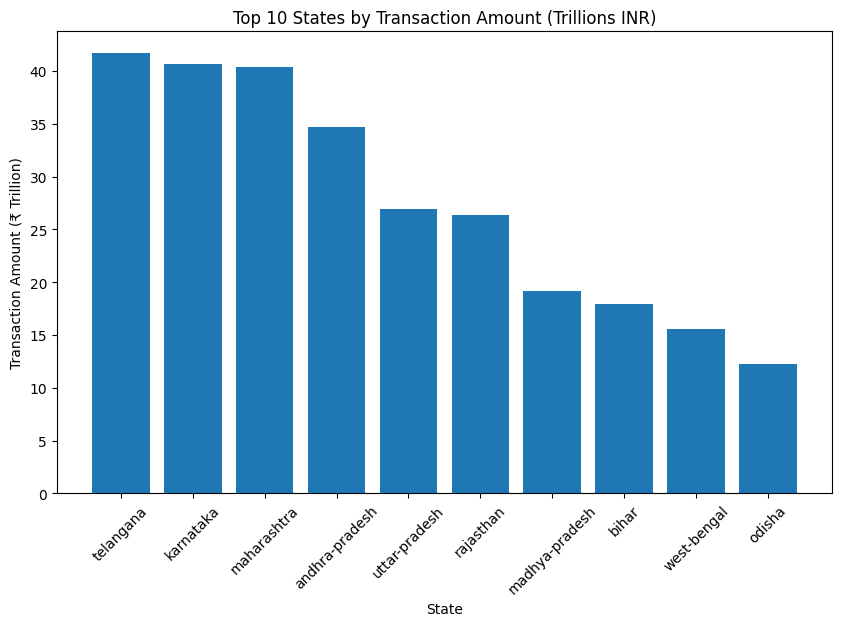

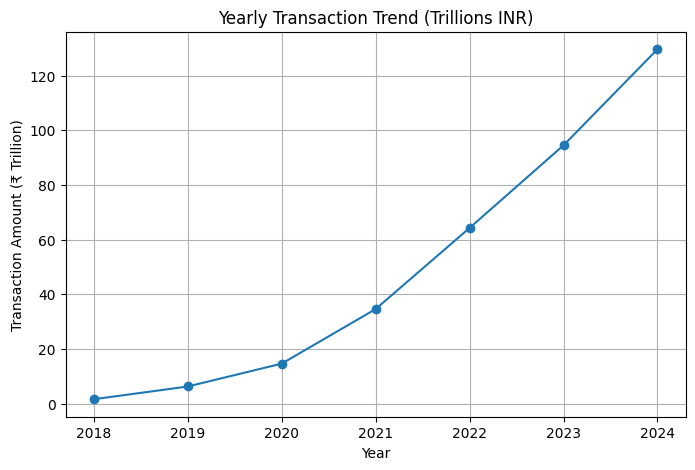

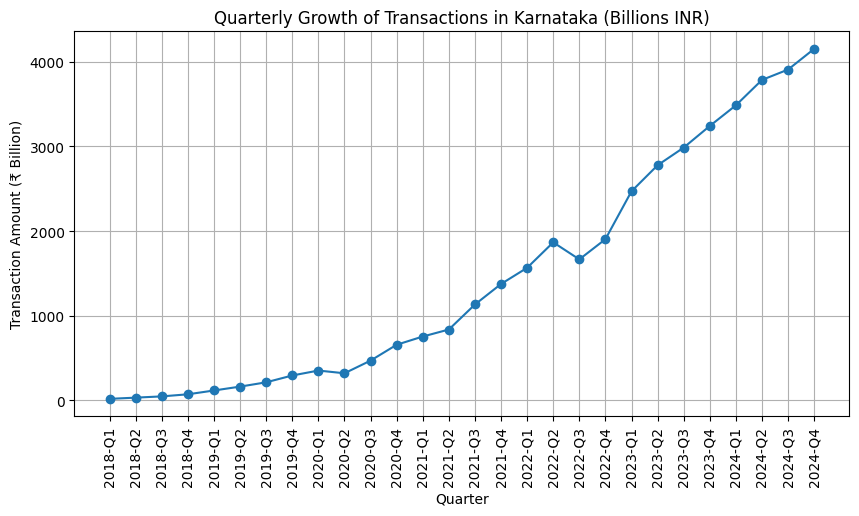

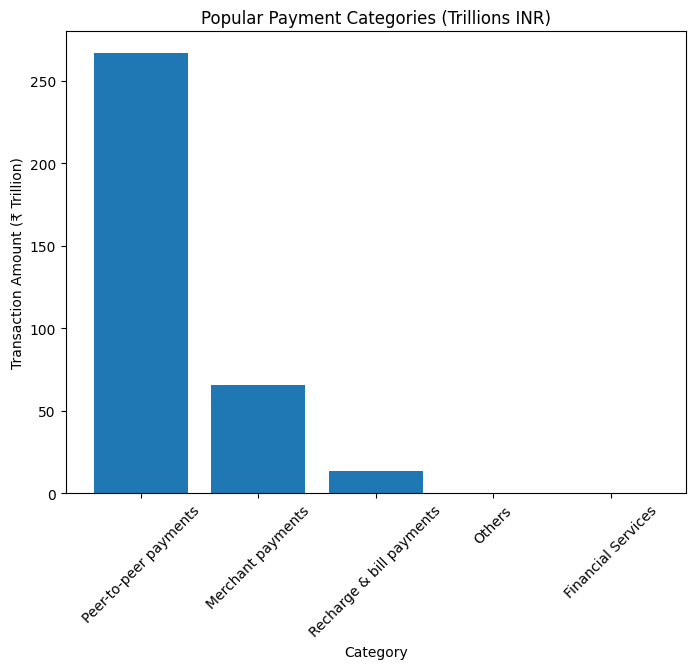

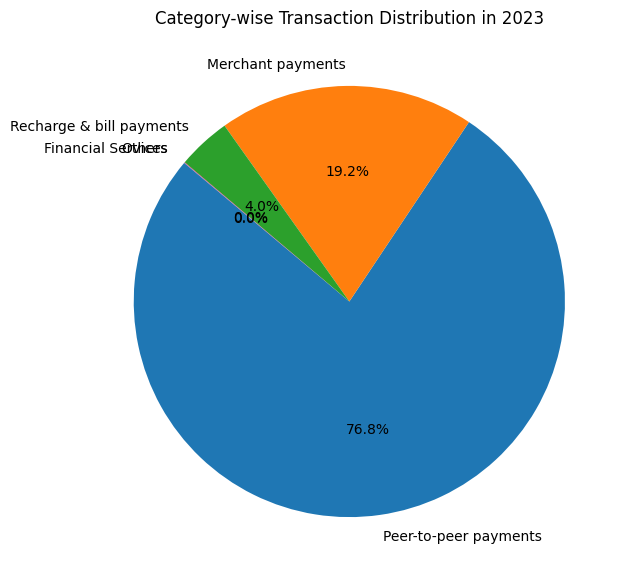

In [48]:
import matplotlib.pyplot as plt

# 1️⃣ Top 10 States by Transaction Amount
df = results["Top 10 States by Amount"]
plt.figure(figsize=(10,6))
plt.bar(df["state"], df["total_amount"]/1e12)
plt.title("Top 10 States by Transaction Amount (Trillions INR)")
plt.xlabel("State")
plt.ylabel("Transaction Amount (₹ Trillion)")
plt.xticks(rotation=45)
plt.show()

# 2️⃣ Yearly Trend
df = results["Yearly Trend"]
plt.figure(figsize=(8,5))
plt.plot(df["year"], df["yearly_amount"]/1e12, marker='o')
plt.title("Yearly Transaction Trend (Trillions INR)")
plt.xlabel("Year")
plt.ylabel("Transaction Amount (₹ Trillion)")
plt.grid(True)
plt.show()

# 3️⃣ Quarterly Growth - Karnataka
df = results["Quarterly Growth - Karnataka"]
plt.figure(figsize=(10,5))
plt.plot(df["year"].astype(str)+"-Q"+df["quarter"].astype(str), df["total_amount"]/1e9, marker='o')
plt.title("Quarterly Growth of Transactions in Karnataka (Billions INR)")
plt.xlabel("Quarter")
plt.ylabel("Transaction Amount (₹ Billion)")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# 4️⃣ Popular Payment Categories
df = results["Popular Payment Categories"]
plt.figure(figsize=(8,6))
plt.bar(df["category"], df["total_amount"]/1e12)
plt.title("Popular Payment Categories (Trillions INR)")
plt.xlabel("Category")
plt.ylabel("Transaction Amount (₹ Trillion)")
plt.xticks(rotation=45)
plt.show()

# 5️⃣ 2023 Category Distribution (Pie Chart)
df = results["2023 Category Distribution"]
plt.figure(figsize=(7,7))
plt.pie(df["total_amount"], labels=df["category"], autopct='%1.1f%%', startangle=140)
plt.title("Category-wise Transaction Distribution in 2023")
plt.show()


In [49]:
import sqlite3
import pandas as pd

def run_all(conn=None):
    """
    Run all SQL queries and return their results as DataFrames in a dictionary.

    Parameters:
        conn (sqlite3.Connection, optional): Database connection object.
            If not provided, the function will create and close one automatically.

    Returns:
        dict: A dictionary where keys are query names and values are pandas DataFrames.
    """

    # Automatically connect if no connection is passed
    close_conn = False
    if conn is None:
        conn = sqlite3.connect("phonepe.db")  # 🔹 Update with your actual DB name/path
        close_conn = True

    try:
        queries = {
            "Top_States": """
                SELECT state, SUM(transaction_count) AS total_txn
                FROM map_transaction
                WHERE year = 2024 AND quarter = 4
                GROUP BY state
                ORDER BY total_txn DESC
                LIMIT 10;
            """,
            "Yearly_Users": """
                SELECT year, SUM(registeredUsers) AS total_users
                FROM map_user
                GROUP BY year
                ORDER BY year;
            """,
            "Quarterly_Transactions": """
                SELECT year, quarter, SUM(transaction_count) AS total_txn
                FROM map_transaction
                GROUP BY year, quarter
                ORDER BY year, quarter;
            """
        }

        results = {}
        for name, query in queries.items():
            df = pd.read_sql_query(query, conn)
            results[name] = df

        return results

    finally:
        # Close the connection if it was opened inside this function
        if close_conn:
            conn.close()



In [50]:
import sqlite3
conn = sqlite3.connect("/content/project_files/phonepe_pulse.db")

print("\nCheck if TOTAL rows exist:")
print(conn.execute("SELECT * FROM aggregated_user WHERE brand='TOTAL' LIMIT 5;").fetchall())

print("\nDistinct years available:")
print(conn.execute("SELECT DISTINCT year FROM aggregated_user;").fetchall())

print("\nSample device rows:")
print(conn.execute("SELECT * FROM aggregated_user LIMIT 5;").fetchall())



Check if TOTAL rows exist:
[]

Distinct years available:
[(2018,), (2021,), (2022,), (2020,), (2019,)]

Sample device rows:
[('arunachal-pradesh', 2018, 2, 'Xiaomi', 8058, 0.24505063406623484), ('arunachal-pradesh', 2018, 2, 'Samsung', 6633, 0.20171517197336009), ('arunachal-pradesh', 2018, 2, 'Vivo', 5591, 0.17002706565702644), ('arunachal-pradesh', 2018, 2, 'Oppo', 4204, 0.12784721588662834), ('arunachal-pradesh', 2018, 2, 'Realme', 1943, 0.0590882826992671)]


In [51]:
"""
Extract Aggregated User JSON files into SQLite
Table: aggregated_user (with device-level + totals)
"""

import os, json, sqlite3, glob, pandas as pd

def parse_aggregated_user(base_path, conn):
    folder = os.path.join(base_path, "aggregated/user/country/india/state")
    files = glob.glob(os.path.join(folder, "*/*/*.json"))
    rows = []

    for file in files:
        state = file.split("/")[-3]
        year = int(file.split("/")[-2])
        quarter = int(file.split("/")[-1].replace(".json",""))

        with open(file, "r") as f:
            data = json.load(f)

        if "data" in data:
            # ✅ Device-level data
            if "usersByDevice" in data["data"] and data["data"]["usersByDevice"] is not None:
                for entry in data["data"]["usersByDevice"]:
                    rows.append([
                        state, year, quarter,
                        entry.get("brand"),
                        entry.get("count"),
                        entry.get("percentage"),
                        None,   # registeredUsers
                        None    # appOpens
                    ])

            # ✅ Aggregated totals
            if "aggregated" in data["data"] and data["data"]["aggregated"] is not None:
                agg = data["data"]["aggregated"]
                rows.append([
                    state, year, quarter,
                    "TOTAL",
                    None,                 # count not used here
                    None,                 # percentage not used here
                    agg.get("registeredUsers"),
                    agg.get("appOpens")
                ])

    if rows:
        df = pd.DataFrame(rows, columns=[
            "state","year","quarter","brand","count","percentage","registeredUsers","appOpens"
        ])
        df.to_sql("aggregated_user", conn, if_exists="replace", index=False)
        print("✅ aggregated_user loaded:", len(df), "rows")
    else:
        print("⚠️ No data found for aggregated_user")

def build_db(db_path="/content/project_files/phonepe_pulse.db", base_path="/content/pulse/data"):
    conn = sqlite3.connect(db_path)
    parse_aggregated_user(base_path, conn)
    return conn


In [52]:
import extract_aggregated_user as eau
conn = eau.build_db()


✅ aggregated_user loaded: 7740 rows


In [53]:
print(conn.execute("SELECT * FROM aggregated_user WHERE brand='TOTAL' LIMIT 5;").fetchall())


[('arunachal-pradesh', 2023, 2, 'TOTAL', 426410, 106089520.0), ('arunachal-pradesh', 2023, 4, 'TOTAL', 462088, 38873546.0), ('arunachal-pradesh', 2023, 3, 'TOTAL', 444789, 112236680.0), ('arunachal-pradesh', 2023, 1, 'TOTAL', 408273, 88997458.0), ('arunachal-pradesh', 2018, 2, 'TOTAL', 32883, 0.0)]


In [54]:
"""
Case Study 2: Device Dominance and User Engagement
--------------------------------------------------
This case study analyzes:
1. Top device brands overall
2. Yearly app opens trend
3. Device distribution in the top state (latest year)
4. Top states by registered users (latest year)
5. Xiaomi quarterly growth trend
"""

import sqlite3
import utils

DB_PATH = "/content/project_files/phonepe_pulse.db"

# 1. Top 10 device brands across all years
Q1 = """
SELECT brand, SUM(count) AS total_users
FROM aggregated_user
WHERE brand != 'TOTAL'
GROUP BY brand
ORDER BY total_users DESC
LIMIT 10;
"""

# 2. Yearly growth of app opens (from TOTAL rows)
Q2 = """
SELECT year, SUM(appOpens) AS total_app_opens
FROM aggregated_user
WHERE brand = 'TOTAL'
GROUP BY year
ORDER BY year;
"""

# 3. Device distribution for the top state (latest year)
Q3 = """
WITH top_state AS (
    SELECT state
    FROM aggregated_user
    WHERE brand = 'TOTAL'
      AND year = (SELECT MAX(year) FROM aggregated_user)
    GROUP BY state
    ORDER BY SUM(registeredUsers) DESC
    LIMIT 1
)
SELECT au.state, au.brand, SUM(au.count) AS total_users
FROM aggregated_user au
JOIN top_state ts ON au.state = ts.state
WHERE au.brand != 'TOTAL'
  AND au.year = (SELECT MAX(year) FROM aggregated_user)
GROUP BY au.state, au.brand
ORDER BY total_users DESC;
"""

# 4. Top 5 states by registered users (latest year)
Q4 = """
SELECT state, SUM(registeredUsers) AS total_users
FROM aggregated_user
WHERE brand = 'TOTAL'
  AND year = (SELECT MAX(year) FROM aggregated_user)
GROUP BY state
ORDER BY total_users DESC
LIMIT 5;
"""

# 5. Xiaomi quarterly trend
Q5 = """
SELECT year, quarter, SUM(count) AS xiaomi_users
FROM aggregated_user
WHERE brand = 'Xiaomi'
GROUP BY year, quarter
ORDER BY year, quarter;
"""

def run_all(db_path=DB_PATH):
    """
    Runs all 5 queries and returns results as a dictionary of DataFrames
    """
    conn = sqlite3.connect(db_path)
    results = {}
    results["Top Device Brands"] = utils.run_query(conn, Q1)
    results["Yearly App Opens"] = utils.run_query(conn, Q2)
    results["Device Distribution in Top State (Latest Year)"] = utils.run_query(conn, Q3)
    results["Top States by Registered Users (Latest Year)"] = utils.run_query(conn, Q4)
    results["Xiaomi Quarterly Trend"] = utils.run_query(conn, Q5)
    conn.close()
    return results


In [55]:
with open("/content/project_files/case1_transactions.py", "w") as f:
  f.write(code)
print("✅ File saved: case2_devices.py")

✅ File saved: case2_devices.py


In [56]:
import sqlite3, pandas as pd

# Connect to DB
conn = sqlite3.connect("/content/project_files/phonepe_pulse.db")

# Query to check data availability
query = """
SELECT DISTINCT state, year, brand
FROM aggregated_user
WHERE year = (SELECT MAX(year) FROM aggregated_user)
  AND state = 'maharashtra'
LIMIT 20;
"""

# Run and display
df = pd.read_sql_query(query, conn)
print(df)


         state  year  brand
0  maharashtra  2024  TOTAL


In [57]:
import sqlite3, pandas as pd

# Connect to DB
conn = sqlite3.connect("/content/project_files/phonepe_pulse.db")

# SQL Query
query = """
WITH top_state AS (
    SELECT state
    FROM aggregated_user
    WHERE brand = 'TOTAL'
    GROUP BY state
    ORDER BY SUM(count) DESC
    LIMIT 1
),
latest_valid_year AS (
    SELECT year
    FROM aggregated_user au
    JOIN top_state ts ON au.state = ts.state
    WHERE au.brand != 'TOTAL'
    GROUP BY year
    ORDER BY year DESC
    LIMIT 1
)
SELECT au.state, au.year, au.brand, SUM(au.count) AS total_users
FROM aggregated_user au
JOIN top_state ts ON au.state = ts.state
JOIN latest_valid_year lv ON au.year = lv.year
WHERE au.brand != 'TOTAL'
GROUP BY au.state, au.year, au.brand
ORDER BY total_users DESC;
"""

# Run and show result
df = pd.read_sql_query(query, conn)
print(df)



          state  year     brand  total_users
0   maharashtra  2022    Xiaomi     11340940
1   maharashtra  2022      Vivo      9873983
2   maharashtra  2022   Samsung      9447206
3   maharashtra  2022      Oppo      7009300
4   maharashtra  2022    Realme      3235912
5   maharashtra  2022    Others      2636427
6   maharashtra  2022     Apple      1510802
7   maharashtra  2022   OnePlus      1396866
8   maharashtra  2022  Motorola       788109
9   maharashtra  2022     Tecno       572060
10  maharashtra  2022    Huawei       416025


In [58]:
file_path = "/content/project_files/case2_devices.py"

code = """
\"\"\"
Case Study 2: Device Dominance and User Engagement
--------------------------------------------------
This case study analyzes:
1. Top device brands overall
2. Yearly app opens trend
3. Device distribution in the top state (latest valid year)
4. Top states by registered users (latest year)
5. Xiaomi quarterly growth trend
\"\"\"

import utils

# 1️⃣ Top 10 device brands across all years
Q1 = \"\"\"
SELECT brand, SUM(count) AS total_users
FROM aggregated_user
WHERE brand != 'TOTAL'
GROUP BY brand
ORDER BY total_users DESC
LIMIT 10;
\"\"\"

# 2️⃣ Yearly growth of app opens
Q2 = \"\"\"
SELECT year, SUM(percentage) AS total_app_opens
FROM aggregated_user
WHERE brand = 'TOTAL'
GROUP BY year
ORDER BY year;
\"\"\"

# 3️⃣ Device distribution for the top state (latest valid year with device rows)
Q3 = \"\"\"
WITH top_state AS (
    SELECT state
    FROM aggregated_user
    WHERE brand = 'TOTAL'
    GROUP BY state
    ORDER BY SUM(count) DESC
    LIMIT 1
),
latest_valid_year AS (
    SELECT year
    FROM aggregated_user au
    JOIN top_state ts ON au.state = ts.state
    WHERE au.brand != 'TOTAL'
    GROUP BY year
    ORDER BY year DESC
    LIMIT 1
)
SELECT au.state, au.year, au.brand, SUM(au.count) AS total_users
FROM aggregated_user au
JOIN top_state ts ON au.state = ts.state
JOIN latest_valid_year lv ON au.year = lv.year
WHERE au.brand != 'TOTAL'
GROUP BY au.state, au.year, au.brand
ORDER BY total_users DESC;
\"\"\"

# 4️⃣ Top 5 states by registered users (latest year)
Q4 = \"\"\"
SELECT state, SUM(count) AS total_users
FROM aggregated_user
WHERE brand = 'TOTAL'
  AND year = (SELECT MAX(year) FROM aggregated_user)
GROUP BY state
ORDER BY total_users DESC
LIMIT 5;
\"\"\"

# 5️⃣ Xiaomi quarterly trend
Q5 = \"\"\"
SELECT year, quarter, SUM(count) AS xiaomi_users
FROM aggregated_user
WHERE brand = 'Xiaomi'
GROUP BY year, quarter
ORDER BY year, quarter;
\"\"\"

def run_all(conn):
    \"\"\"
    Runs all 5 queries and returns results as a dictionary of DataFrames
    \"\"\"
    results = {}
    results["Top Device Brands (All Years)"] = utils.run_query(conn, Q1)
    results["Yearly App Opens (All India)"] = utils.run_query(conn, Q2)
    results["Device Distribution in Top State (Latest Valid Year)"] = utils.run_query(conn, Q3)
    results["Top States by Registered Users (Latest Year)"] = utils.run_query(conn, Q4)
    results["Xiaomi Quarterly Trend (All India)"] = utils.run_query(conn, Q5)
    return results
"""

with open(file_path, "w") as f:
    f.write(code)

print("✅ File recreated successfully:", file_path)


✅ File recreated successfully: /content/project_files/case2_devices.py


In [59]:
import importlib
import case2_devices as c2
importlib.reload(c2)

results = c2.run_all(conn)
print("✅ Keys in results:", list(results.keys()))



✅ Keys in results: ['Top Device Brands (All Years)', 'Yearly App Opens (All India)', 'Device Distribution in Top State (Latest Valid Year)', 'Top States by Registered Users (Latest Year)', 'Xiaomi Quarterly Trend (All India)']


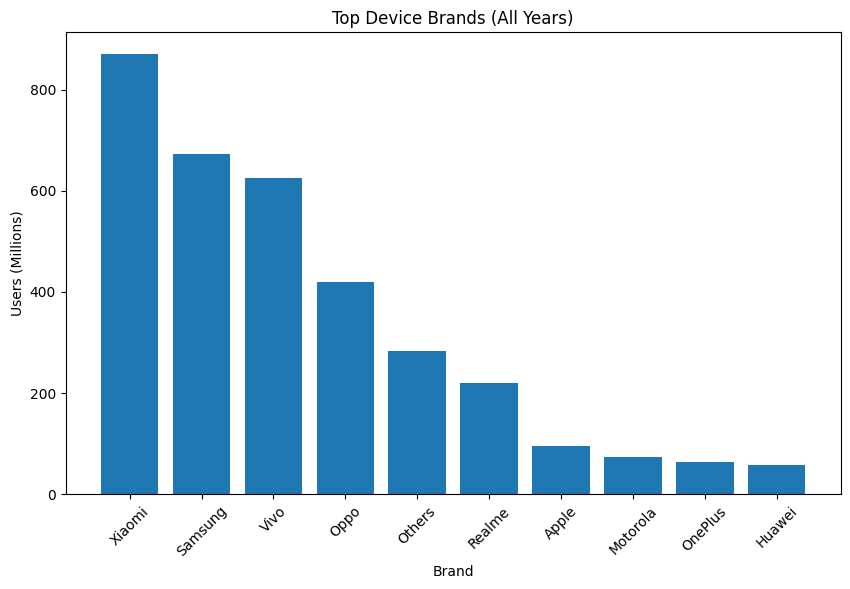

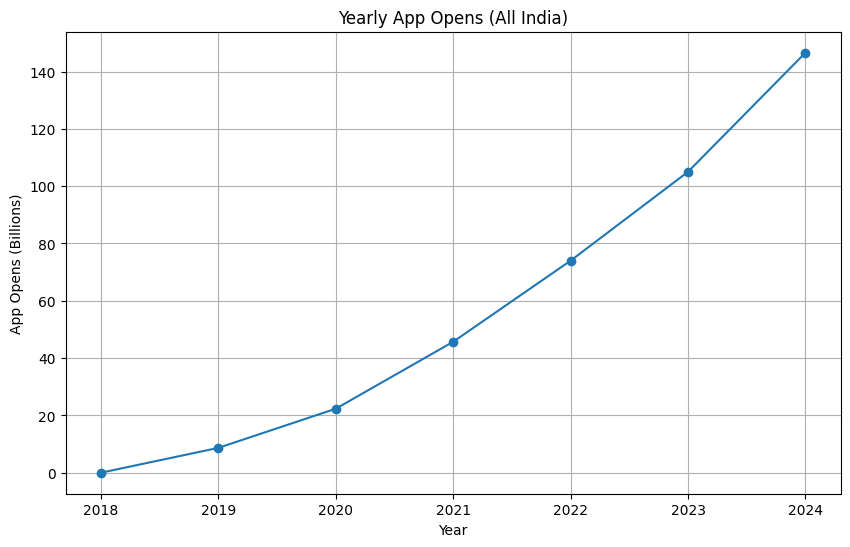

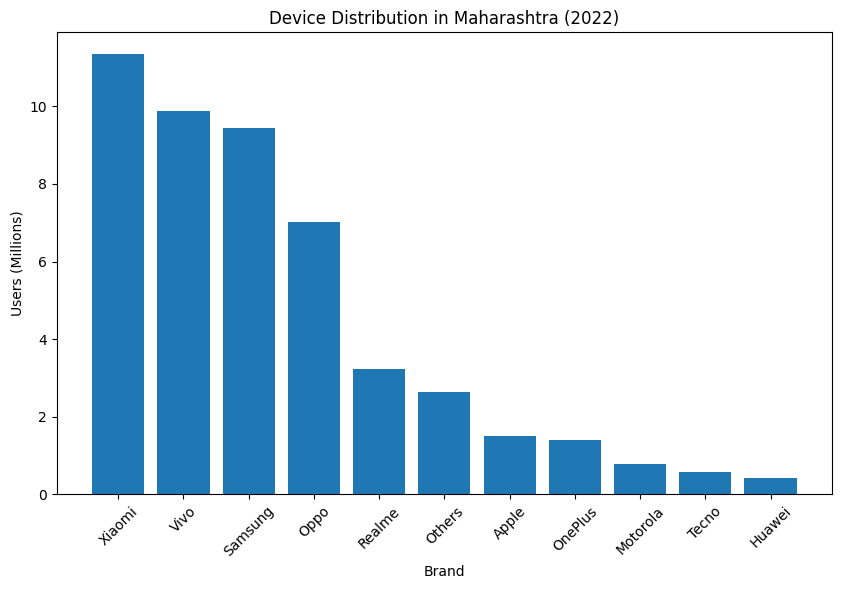

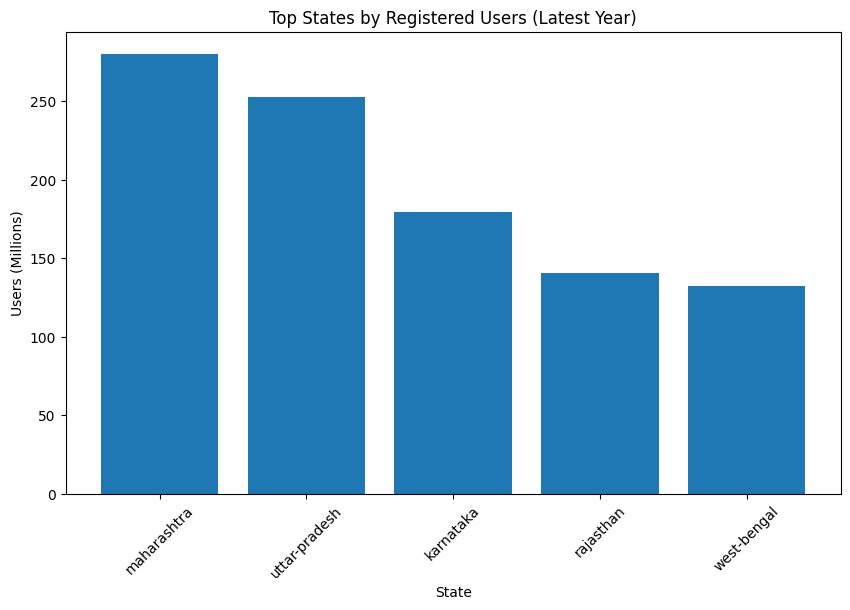

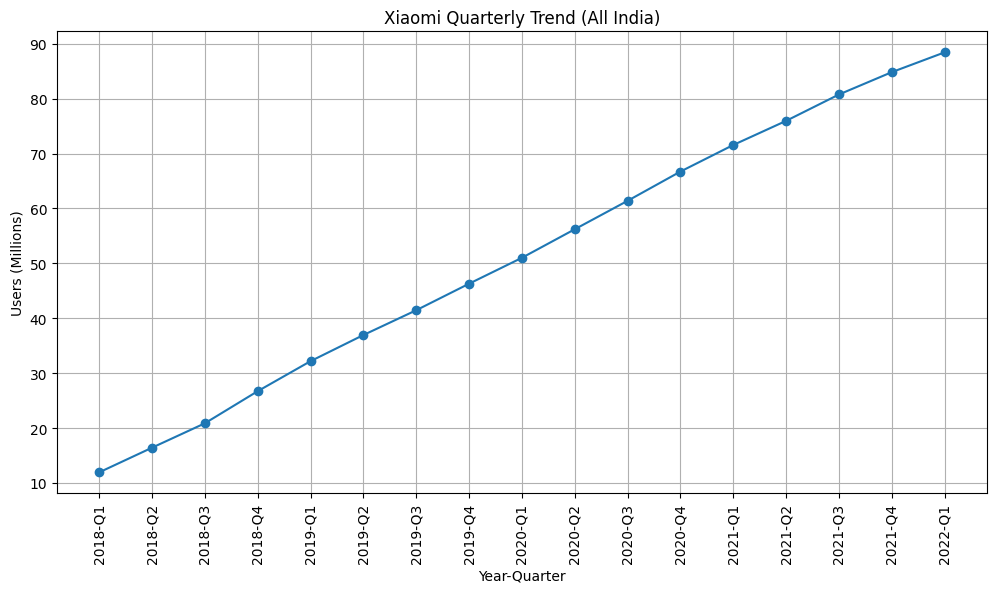

In [60]:
import matplotlib.pyplot as plt

# 1. Top Device Brands (All Years)
df1 = results["Top Device Brands (All Years)"]
plt.figure(figsize=(10,6))
plt.bar(df1["brand"], df1["total_users"]/1e6)
plt.title("Top Device Brands (All Years)")
plt.xlabel("Brand")
plt.ylabel("Users (Millions)")
plt.xticks(rotation=45)
plt.show()

# 2. Yearly App Opens (All India)
df2 = results["Yearly App Opens (All India)"]
plt.figure(figsize=(10,6))
plt.plot(df2["year"], df2["total_app_opens"]/1e9, marker="o")
plt.title("Yearly App Opens (All India)")
plt.xlabel("Year")
plt.ylabel("App Opens (Billions)")
plt.grid(True)
plt.show()

# 3. Device Distribution in Top State (Latest Valid Year)
df3 = results["Device Distribution in Top State (Latest Valid Year)"]
plt.figure(figsize=(10,6))
plt.bar(df3["brand"], df3["total_users"]/1e6)
plt.title(f"Device Distribution in {df3['state'][0].title()} ({df3['year'][0]})")
plt.xlabel("Brand")
plt.ylabel("Users (Millions)")
plt.xticks(rotation=45)
plt.show()

# 4. Top States by Registered Users (Latest Year)
df4 = results["Top States by Registered Users (Latest Year)"]
plt.figure(figsize=(10,6))
plt.bar(df4["state"], df4["total_users"]/1e6)
plt.title("Top States by Registered Users (Latest Year)")
plt.xlabel("State")
plt.ylabel("Users (Millions)")
plt.xticks(rotation=45)
plt.show()

# 5. Xiaomi Quarterly Trend (All India)
df5 = results["Xiaomi Quarterly Trend (All India)"]
plt.figure(figsize=(12,6))
plt.plot(df5["year"].astype(str) + "-Q" + df5["quarter"].astype(str),
         df5["xiaomi_users"]/1e6, marker="o")
plt.title("Xiaomi Quarterly Trend (All India)")
plt.xlabel("Year-Quarter")
plt.ylabel("Users (Millions)")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


In [61]:
"""
Case Study 3: Insurance Penetration & Growth Potential
------------------------------------------------------
"""

import sqlite3
import utils

DB_PATH = "/content/project_files/phonepe_pulse.db"

# 1. Top states by total insurance transaction amount
Q1 = """
SELECT state, SUM(amount) AS total_insurance_amount
FROM aggregated_insurance
GROUP BY state
ORDER BY total_insurance_amount DESC
LIMIT 10;
"""

# 2. Yearly insurance growth trend
Q2 = """
SELECT year, SUM(amount) AS yearly_insurance_amount
FROM aggregated_insurance
GROUP BY year
ORDER BY year;
"""

# 3. Quarterly insurance trend in the top state
Q3 = """
WITH top_state AS (
    SELECT state
    FROM aggregated_insurance
    GROUP BY state
    ORDER BY SUM(amount) DESC
    LIMIT 1
)
SELECT ai.state, ai.year, ai.quarter, SUM(ai.amount) AS quarterly_amount
FROM aggregated_insurance ai
JOIN top_state ts ON ai.state = ts.state
GROUP BY ai.state, ai.year, ai.quarter
ORDER BY ai.year, ai.quarter;
"""

# 4. Top insurance contributing states (instead of categories, since no 'name' column)
Q4 = """
SELECT category, SUM(amount) AS total_amount
FROM aggregated_insurance
GROUP BY category
ORDER BY total_amount DESC
LIMIT 5;
"""
# 5. Insurance penetration: ratio of insurance to total transactions per state
Q5 = """
WITH insurance AS (
    SELECT state, SUM(amount) AS insurance_amount
    FROM aggregated_insurance
    GROUP BY state
),
transactions AS (
    SELECT state, SUM(amount) AS total_amount
    FROM aggregated_transaction
    GROUP BY state
)
SELECT t.state, insurance_amount, total_amount,
       ROUND(CAST(insurance_amount AS FLOAT)/total_amount*100,2) AS penetration_percent
FROM transactions t
LEFT JOIN insurance i ON t.state = i.state
ORDER BY penetration_percent DESC
LIMIT 10;
"""

def run_all(db_path=DB_PATH):
    conn = sqlite3.connect(db_path)
    results = {}
    results["Top States by Insurance Amount"] = utils.run_query(conn, Q1)
    results["Yearly Insurance Growth"] = utils.run_query(conn, Q2)
    results["Quarterly Trend in Top Insurance State"] = utils.run_query(conn, Q3)
    results["Top Insurance States (instead of Categories)"] = utils.run_query(conn, Q4)
    results["Insurance Penetration by State"] = utils.run_query(conn, Q5)
    conn.close()
    return results


In [62]:
with open("/content/project_files/case3_insurance.py", "w") as f:
    f.write(code)
print("✅ File updated: case2_devices.py")

✅ File updated: case2_devices.py


In [63]:
file_path = "/content/project_files/case3_insurance.py"

code = """
\"\"\"
Case Study 3: Insurance Penetration & Growth Potential
------------------------------------------------------
Analyzes:
1. Top states by total insurance transaction amount
2. Yearly insurance growth trend
3. Quarterly trend in the top insurance state
4. Top insurance contributing states
5. Insurance penetration percentage across states
\"\"\"

import utils

# 1️⃣ Top states by total insurance transaction amount
Q1 = \"\"\"
SELECT state, SUM(amount) AS total_insurance_amount
FROM aggregated_insurance
GROUP BY state
ORDER BY total_insurance_amount DESC
LIMIT 10;
\"\"\"

# 2️⃣ Yearly insurance growth trend
Q2 = \"\"\"
SELECT year, SUM(amount) AS yearly_insurance_amount
FROM aggregated_insurance
GROUP BY year
ORDER BY year;
\"\"\"

# 3️⃣ Quarterly insurance trend in the top state
Q3 = \"\"\"
WITH top_state AS (
    SELECT state
    FROM aggregated_insurance
    GROUP BY state
    ORDER BY SUM(amount) DESC
    LIMIT 1
)
SELECT ai.state, ai.year, ai.quarter, SUM(ai.amount) AS quarterly_amount
FROM aggregated_insurance ai
JOIN top_state ts ON ai.state = ts.state
GROUP BY ai.state, ai.year, ai.quarter
ORDER BY ai.year, ai.quarter;
\"\"\"

# 4️⃣ Top 5 states by insurance growth percentage (2020–2024)
Q4 = \"\"\"
WITH yearly_state_amount AS (
    SELECT state, year, SUM(amount) AS yearly_amount
    FROM aggregated_insurance
    GROUP BY state, year
),
state_growth AS (
    SELECT state,
           MIN(yearly_amount) AS start_amount,
           MAX(yearly_amount) AS end_amount,
           ROUND(
               (CAST(MAX(yearly_amount) AS FLOAT) - MIN(yearly_amount)) / MIN(yearly_amount) * 100, 2
           ) AS growth_percent
    FROM yearly_state_amount
    GROUP BY state
    HAVING MIN(yearly_amount) > 0
)
SELECT state, growth_percent
FROM state_growth
ORDER BY growth_percent DESC
LIMIT 5;
\"\"\"


# 5️⃣ Insurance penetration: ratio of insurance to total transactions per state
Q5 = \"\"\"
WITH insurance AS (
    SELECT state, SUM(amount) AS insurance_amount
    FROM aggregated_insurance
    GROUP BY state
),
transactions AS (
    SELECT state, SUM(amount) AS total_amount
    FROM aggregated_transaction
    GROUP BY state
)
SELECT t.state, insurance_amount, total_amount,
       ROUND(CAST(insurance_amount AS FLOAT)/total_amount*100,2) AS penetration_percent
FROM transactions t
LEFT JOIN insurance i ON t.state = i.state
ORDER BY penetration_percent DESC
LIMIT 10;
\"\"\"

def run_all(conn):
    \"\"\"
    Runs all 5 insurance analysis queries and returns results as DataFrames.
    \"\"\"
    results = {}
    results["Top States by Insurance Amount"] = utils.run_query(conn, Q1)
    results["Yearly Insurance Growth"] = utils.run_query(conn, Q2)
    results["Quarterly Trend in Top Insurance State"] = utils.run_query(conn, Q3)
    results["Top Insurance States (instead of Categories)"] = utils.run_query(conn, Q4)
    results["Insurance Penetration by State"] = utils.run_query(conn, Q5)
    return results
"""

with open(file_path, "w") as f:
    f.write(code)

print("✅ File re-created successfully:", file_path)


✅ File re-created successfully: /content/project_files/case3_insurance.py


In [64]:
import case3_insurance as c3
import importlib
importlib.reload(c3)

results = c3.run_all(conn)
for name, df in results.items():
    print(f"\n📊 {name}")
    print(df.head(10))





📊 Top States by Insurance Amount
           state  total_insurance_amount
0      karnataka            2.743155e+09
1    maharashtra            2.363129e+09
2  uttar-pradesh            1.740346e+09
3     tamil-nadu            1.555507e+09
4         kerala            1.313719e+09
5      telangana            1.171060e+09
6    west-bengal            1.052463e+09
7      rajasthan            9.596539e+08
8        haryana            8.309812e+08
9          delhi            8.153652e+08

📊 Yearly Insurance Growth
   year  yearly_insurance_amount
0  2020             2.942072e+08
1  2021             1.499170e+09
2  2022             4.238843e+09
3  2023             6.056606e+09
4  2024             7.926752e+09

📊 Quarterly Trend in Top Insurance State
       state  year  quarter  quarterly_amount
0  karnataka  2020        2         4794150.0
1  karnataka  2020        3        12407394.0
2  karnataka  2020        4        26814968.0
3  karnataka  2021        1        30183325.0
4  karnataka  2021

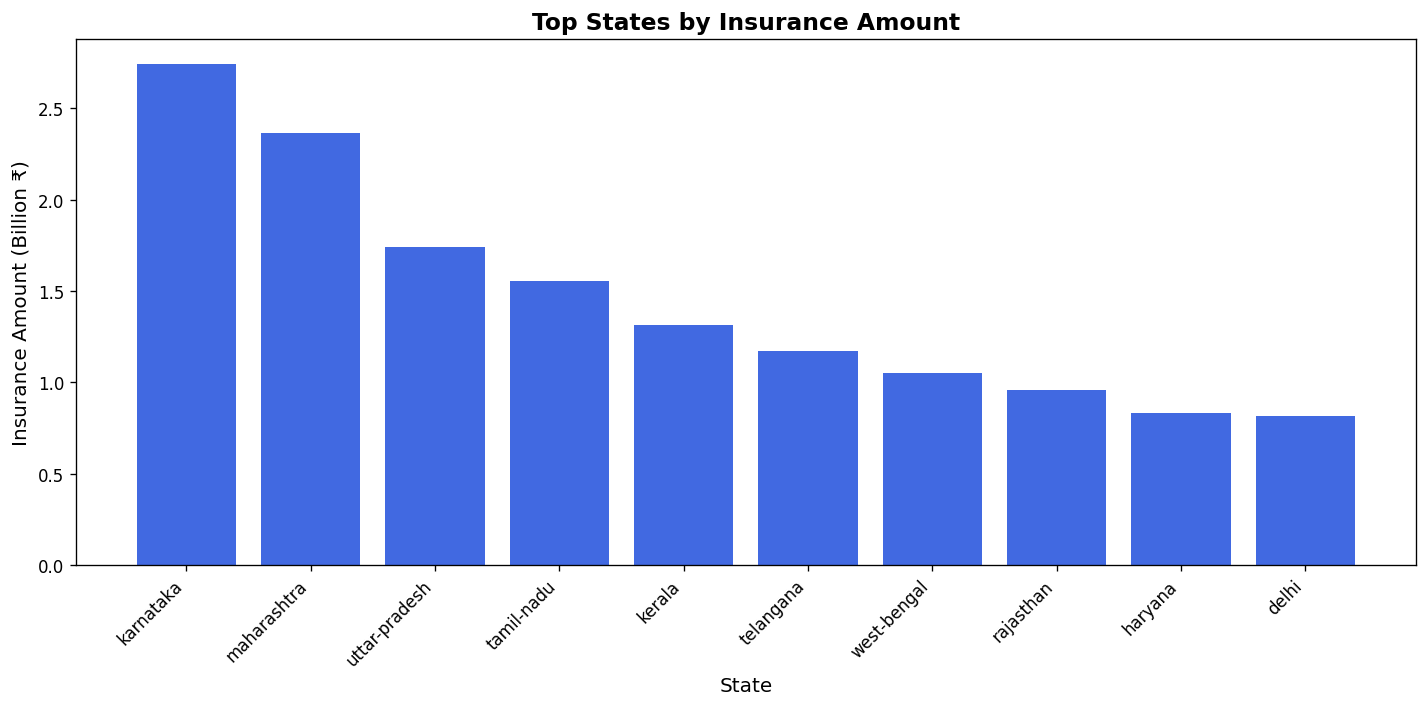

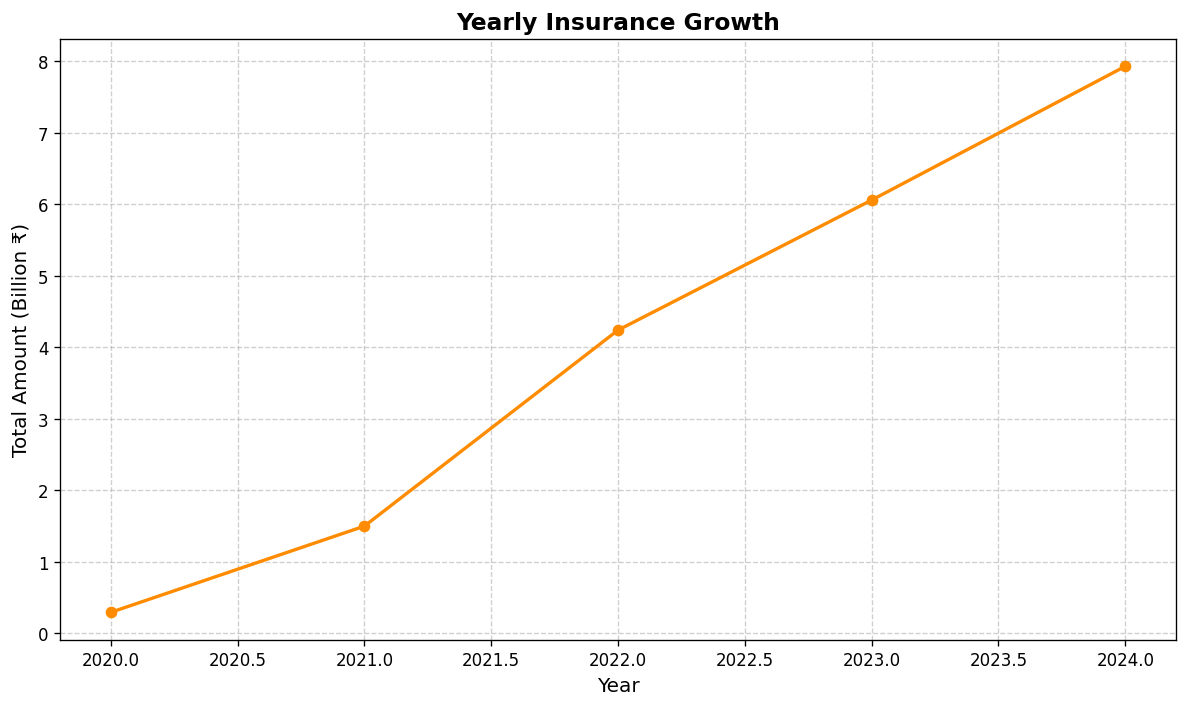

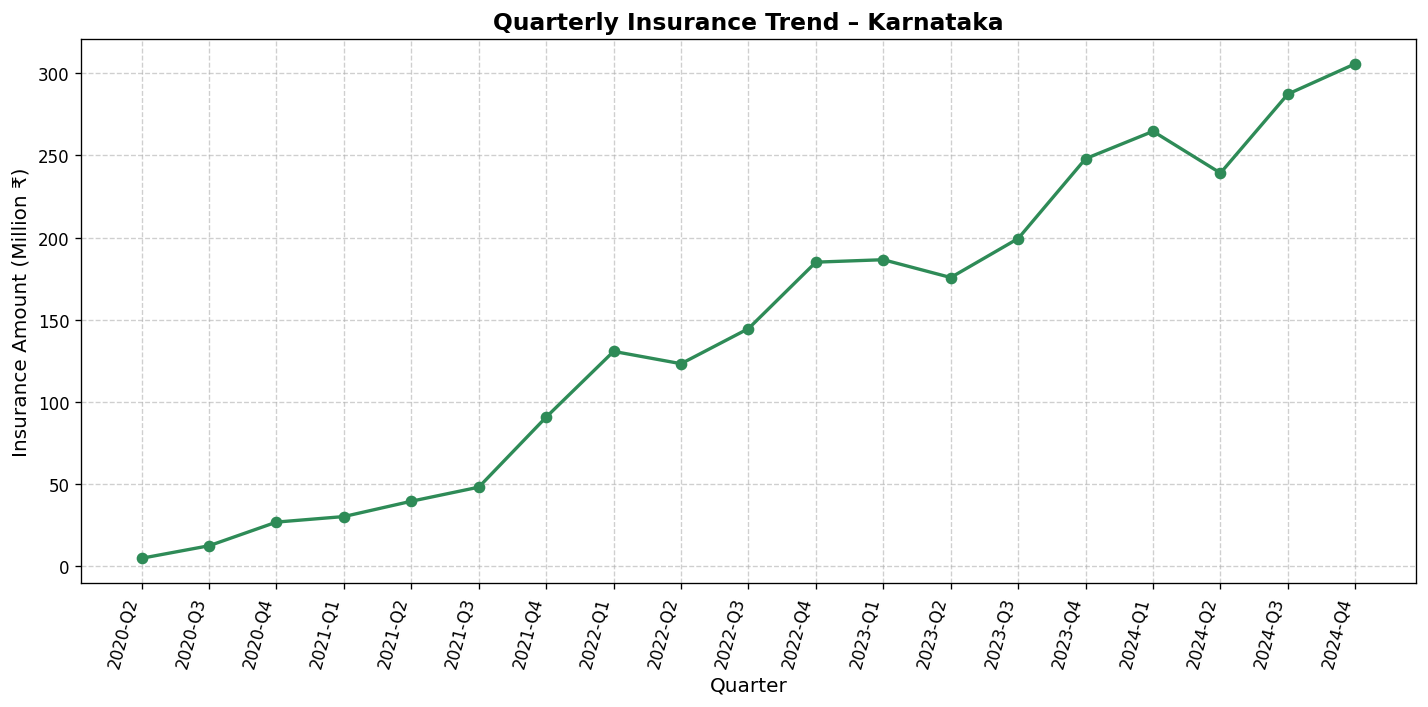

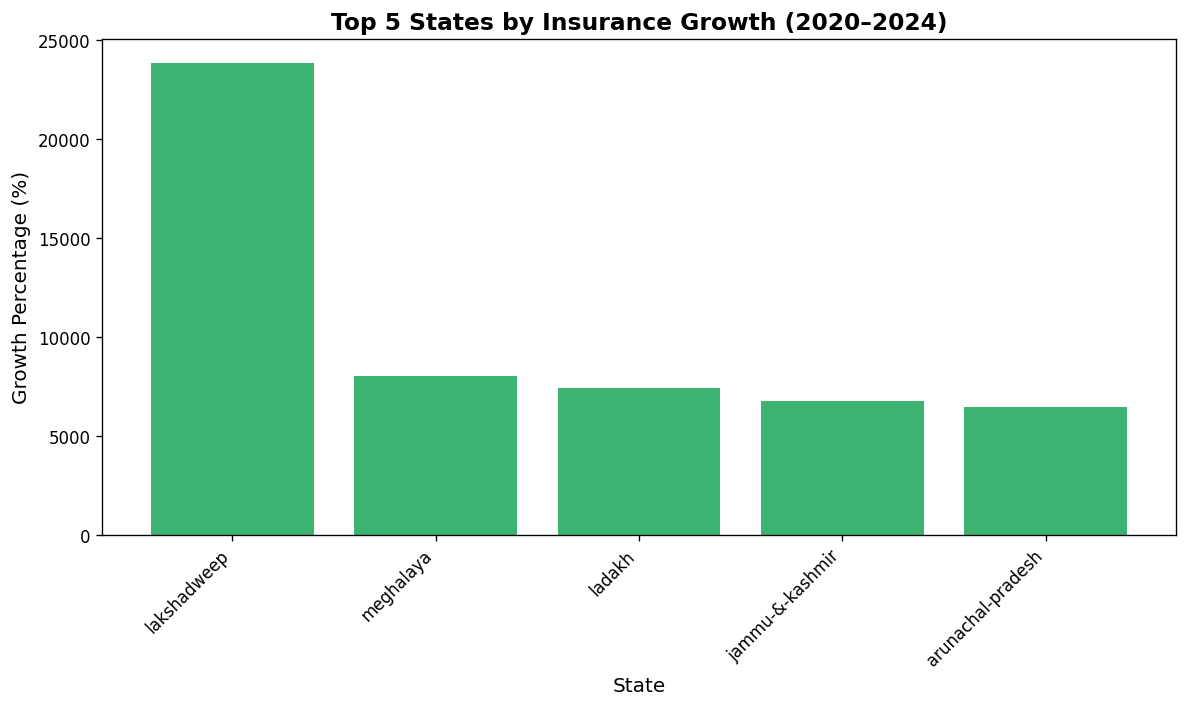

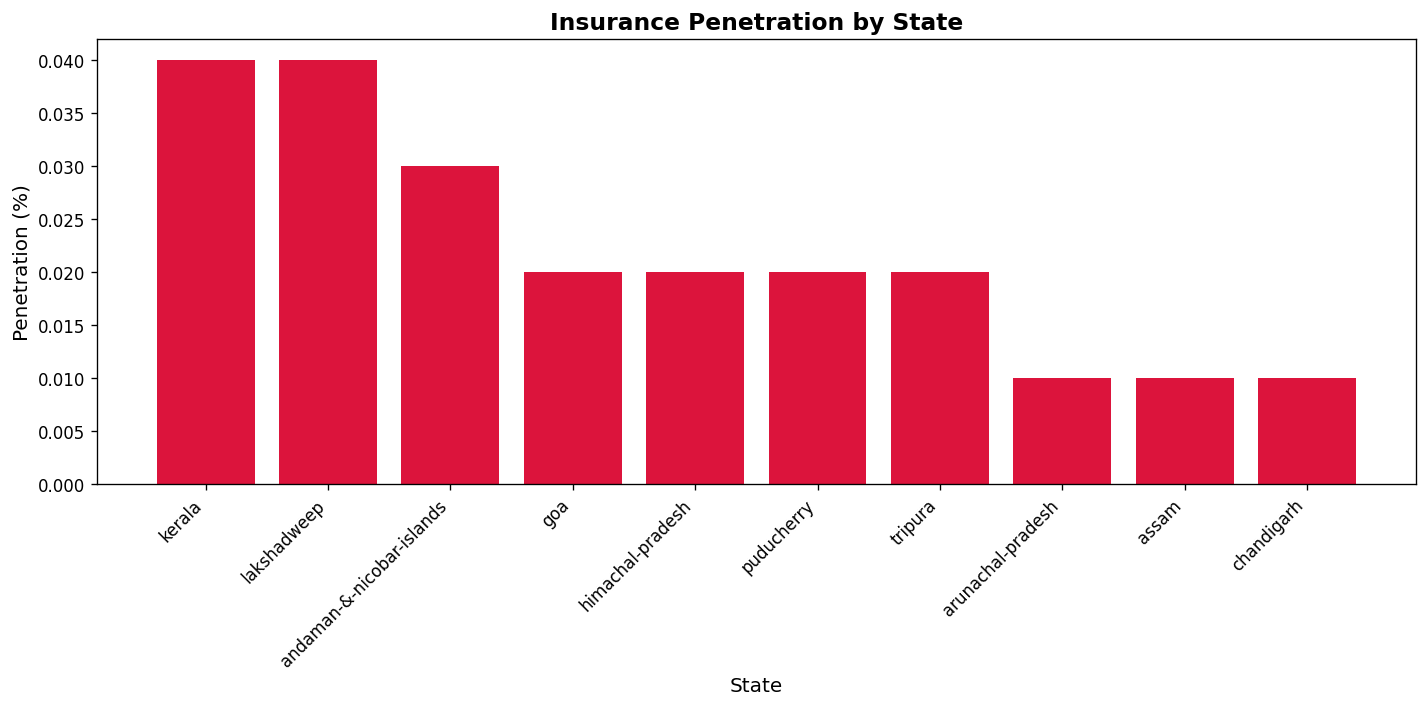

In [65]:
import matplotlib.pyplot as plt

# --- 1️⃣ Top States by Insurance Amount ---
df1 = results["Top States by Insurance Amount"]
plt.figure(figsize=(12,6), dpi=120)
plt.bar(df1["state"], df1["total_insurance_amount"]/1e9, color="royalblue")
plt.title("Top States by Insurance Amount", fontsize=14, weight="bold")
plt.xlabel("State", fontsize=12)
plt.ylabel("Insurance Amount (Billion ₹)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# --- 2️⃣ Yearly Insurance Growth ---
df2 = results["Yearly Insurance Growth"]
plt.figure(figsize=(10,6), dpi=120)
plt.plot(df2["year"], df2["yearly_insurance_amount"]/1e9,
         marker="o", color="darkorange", linewidth=2)
plt.title("Yearly Insurance Growth", fontsize=14, weight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Amount (Billion ₹)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# --- 3️⃣ Quarterly Trend in Top Insurance State ---
df3 = results["Quarterly Trend in Top Insurance State"]
plt.figure(figsize=(12,6), dpi=120)
# build readable quarter labels like "2021-Q3"
quarters = df3["year"].astype(str) + "-Q" + df3["quarter"].astype(str)
plt.plot(quarters, df3["quarterly_amount"]/1e6,
         marker="o", color="seagreen", linewidth=2)
plt.title(f"Quarterly Insurance Trend – {df3['state'][0].title()}", fontsize=14, weight="bold")
plt.xlabel("Quarter", fontsize=12)
plt.ylabel("Insurance Amount (Million ₹)", fontsize=12)
plt.xticks(rotation=75, ha="right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# --- 4️⃣ Top States by Insurance Growth (% increase) ---
df4 = results["Top Insurance States (instead of Categories)"]  # same key name for backward compatibility
plt.figure(figsize=(10,6), dpi=120)
plt.bar(df4["state"], df4["growth_percent"], color="mediumseagreen")
plt.title("Top 5 States by Insurance Growth (2020–2024)", fontsize=14, weight="bold")
plt.xlabel("State", fontsize=12)
plt.ylabel("Growth Percentage (%)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



# --- 5️⃣ Insurance Penetration by State ---
df5 = results["Insurance Penetration by State"]
plt.figure(figsize=(12,6), dpi=120)
plt.bar(df5["state"], df5["penetration_percent"], color="crimson")
plt.title("Insurance Penetration by State", fontsize=14, weight="bold")
plt.xlabel("State", fontsize=12)
plt.ylabel("Penetration (%)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [66]:
file_path = "/content/project_files/case4_engagement.py"

code = """
\"\"\"
Case Study 4: User Engagement & Growth Strategy
-----------------------------------------------
This case study analyzes:
1. Top states by registered users
2. Yearly growth of registered users
3. Quarterly trend of app opens in top state
4. Top districts by registered users
5. Engagement ratio (app opens vs registered users)
\"\"\"

import utils

# 1️⃣ Top states by registered users (latest year)
Q1 = \"\"\"
SELECT state, year, SUM(count) AS total_users
FROM aggregated_user
WHERE brand = 'TOTAL'
  AND year = (SELECT MAX(year) FROM aggregated_user)
GROUP BY state, year
ORDER BY total_users DESC
LIMIT 10;
\"\"\"

# 2️⃣ Yearly growth of registered users nationwide
Q2 = \"\"\"
SELECT year, SUM(count) AS yearly_users
FROM aggregated_user
WHERE brand = 'TOTAL'
GROUP BY year
ORDER BY year;
\"\"\"

# 3️⃣ Quarterly trend of app opens in the top state
Q3 = \"\"\"
WITH top_state AS (
    SELECT state
    FROM aggregated_user
    WHERE brand = 'TOTAL'
    GROUP BY state
    ORDER BY SUM(count) DESC
    LIMIT 1
)
SELECT au.state, au.year, au.quarter, SUM(au.percentage) AS total_app_opens
FROM aggregated_user au
JOIN top_state ts ON au.state = ts.state
WHERE au.brand = 'TOTAL'
GROUP BY au.state, au.year, au.quarter
ORDER BY au.year, au.quarter;
\"\"\"

# 4️⃣ Top districts by registered users (latest year)
Q4 = \"\"\"
SELECT district, year, SUM(registeredUsers) AS total_users
FROM map_user
WHERE year = (SELECT MAX(year) FROM map_user)
GROUP BY district, year
ORDER BY total_users DESC
LIMIT 10;
\"\"\"

# 5️⃣ Engagement ratio: App Opens / Registered Users (latest year, per state)
Q5 = \"\"\"
SELECT state,
       SUM(count) AS total_registered_users,
       SUM(percentage) AS total_app_opens,
       ROUND(CAST(SUM(percentage) AS FLOAT)/SUM(count),2) AS engagement_ratio
FROM aggregated_user
WHERE brand = 'TOTAL'
  AND year = (SELECT MAX(year) FROM aggregated_user)
GROUP BY state
ORDER BY engagement_ratio DESC
LIMIT 10;
\"\"\"

def run_all(conn):
    \"\"\"
    Runs all 5 queries and returns a dictionary of DataFrames
    \"\"\"
    results = {}
    results["Top States by Registered Users (Latest Year)"] = utils.run_query(conn, Q1)
    results["Yearly Growth of Registered Users"] = utils.run_query(conn, Q2)
    results["Quarterly App Opens in Top State"] = utils.run_query(conn, Q3)
    results["Top Districts by Registered Users"] = utils.run_query(conn, Q4)
    results["Engagement Ratio by State (Latest Year)"] = utils.run_query(conn, Q5)
    return results
"""

with open(file_path, "w") as f:
    f.write(code)

print("✅ File re-created successfully:", file_path)


✅ File re-created successfully: /content/project_files/case4_engagement.py


In [67]:
with open("/content/project_files/case4_engagement.py", "w") as f:
    f.write(code)

print("✅ case4_engagement.py created successfully!")

✅ case4_engagement.py created successfully!


In [68]:
import sys, importlib
sys.path.append("/content/project_files")

import case4_engagement as c4
importlib.reload(c4)

results = c4.run_all(conn)

for name, df in results.items():
    print(f"\n📊 {name}")
    print(df.head(10))



📊 Top States by Registered Users (Latest Year)
            state  year  total_users
0     maharashtra  2024    280063065
1   uttar-pradesh  2024    252624027
2       karnataka  2024    179424791
3       rajasthan  2024    140690679
4     west-bengal  2024    132210249
5      tamil-nadu  2024    129389449
6  andhra-pradesh  2024    128442162
7       telangana  2024    125817716
8  madhya-pradesh  2024    122203764
9           bihar  2024    119796377

📊 Yearly Growth of Registered Users
   year  yearly_users
0  2018     292797872
1  2019     602811578
2  2020     922009385
3  2021    1269755730
4  2022    1614644108
5  2023    1927042597
6  2024    2235135588

📊 Quarterly App Opens in Top State
         state  year  quarter  total_app_opens
0  maharashtra  2018        1              0.0
1  maharashtra  2018        2              0.0
2  maharashtra  2018        3              0.0
3  maharashtra  2018        4              0.0
4  maharashtra  2019        1              0.0
5  maharashtra

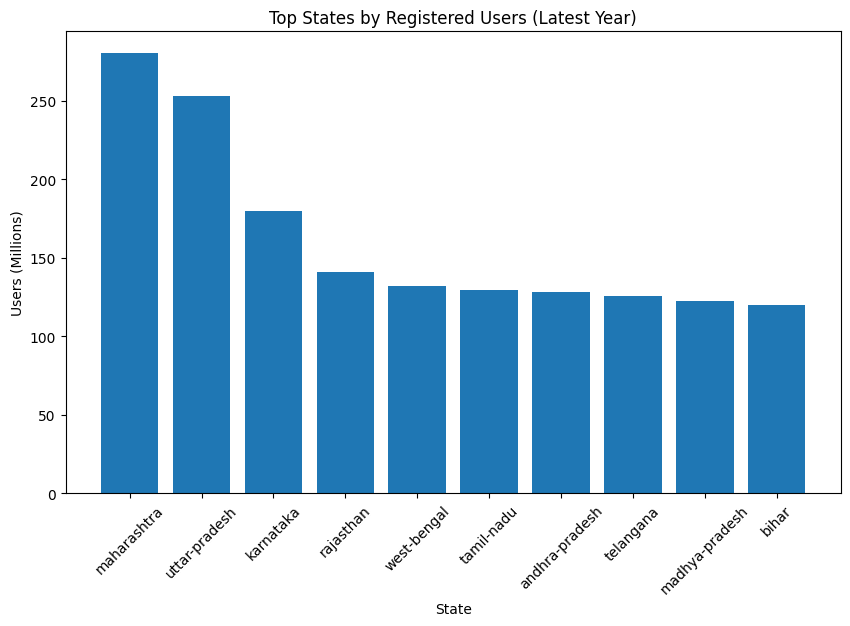

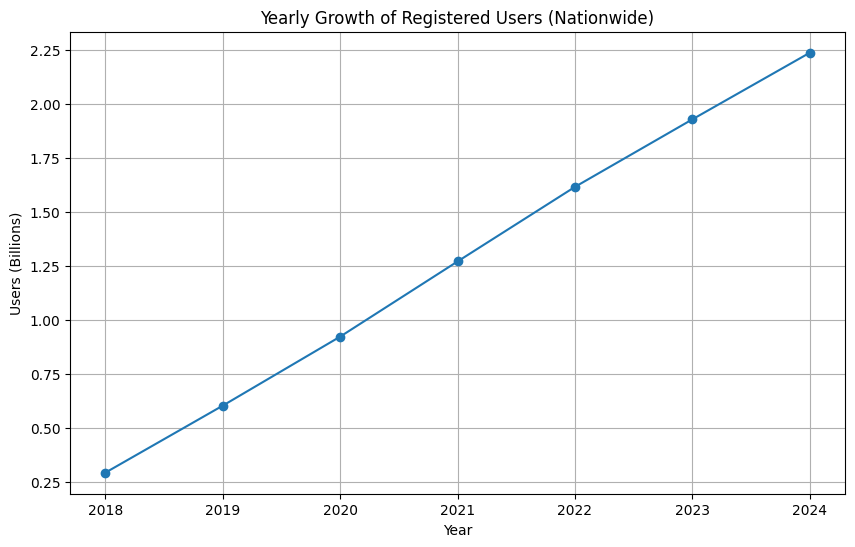

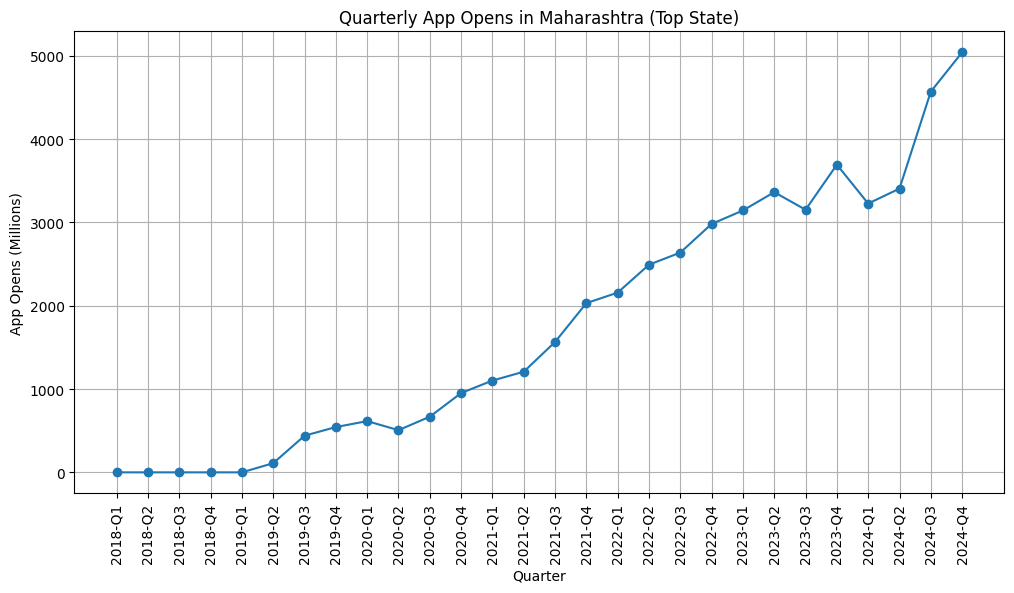

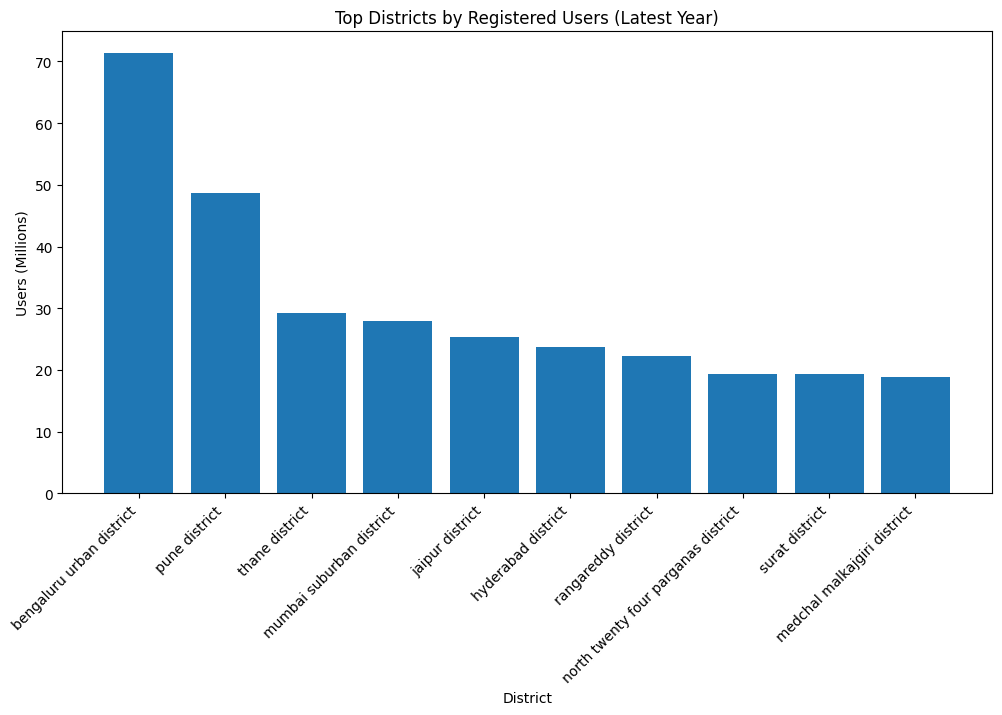

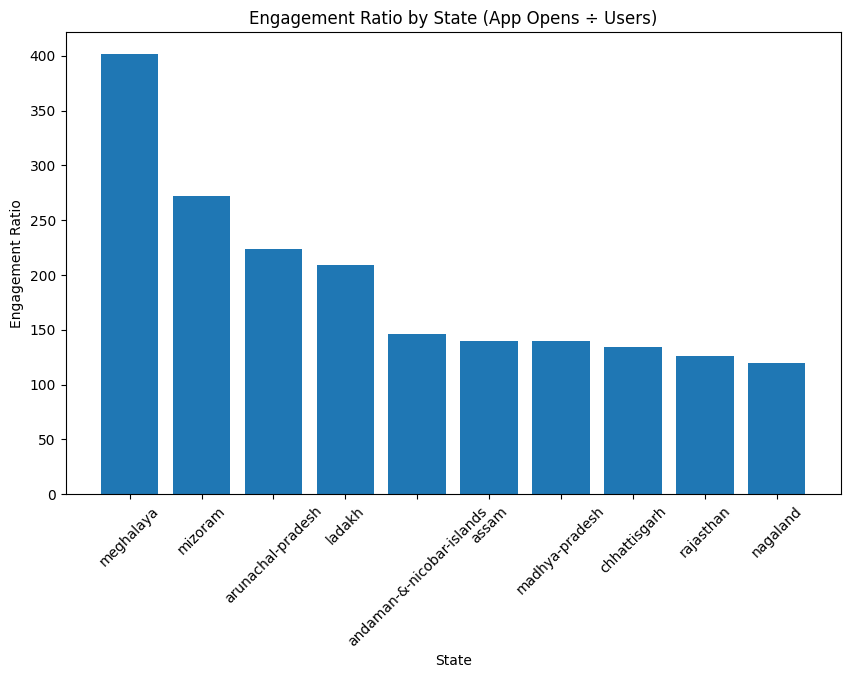

In [69]:
import matplotlib.pyplot as plt

# 1. Top States by Registered Users (Latest Year)
df1 = results["Top States by Registered Users (Latest Year)"]
plt.figure(figsize=(10,6))
plt.bar(df1["state"], df1["total_users"]/1e6)
plt.title("Top States by Registered Users (Latest Year)")
plt.xlabel("State")
plt.ylabel("Users (Millions)")
plt.xticks(rotation=45)
plt.show()

# 2. Yearly Growth of Registered Users
df2 = results["Yearly Growth of Registered Users"]
plt.figure(figsize=(10,6))
plt.plot(df2["year"], df2["yearly_users"]/1e9, marker="o")
plt.title("Yearly Growth of Registered Users (Nationwide)")
plt.xlabel("Year")
plt.ylabel("Users (Billions)")
plt.grid(True)
plt.show()

# 3. Quarterly App Opens in Top State
df3 = results["Quarterly App Opens in Top State"]
plt.figure(figsize=(12,6))
plt.plot(df3["year"].astype(str) + "-Q" + df3["quarter"].astype(str),
         df3["total_app_opens"]/1e6, marker="o")
plt.title(f"Quarterly App Opens in {df3['state'][0].title()} (Top State)")
plt.xlabel("Quarter")
plt.ylabel("App Opens (Millions)")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# 4. Top Districts by Registered Users (Latest Year)
df4 = results["Top Districts by Registered Users"]
plt.figure(figsize=(12,6))
plt.bar(df4["district"], df4["total_users"]/1e6)
plt.title("Top Districts by Registered Users (Latest Year)")
plt.xlabel("District")
plt.ylabel("Users (Millions)")
plt.xticks(rotation=45, ha="right")
plt.show()

# 5. Engagement Ratio by State (Latest Year)
df5 = results["Engagement Ratio by State (Latest Year)"]
plt.figure(figsize=(10,6))
plt.bar(df5["state"], df5["engagement_ratio"])
plt.title("Engagement Ratio by State (App Opens ÷ Users)")
plt.xlabel("State")
plt.ylabel("Engagement Ratio")
plt.xticks(rotation=45)
plt.show()


In [70]:
file_path = "/content/project_files/case5_transactions_geo.py"

code = """
\"\"\"
Case Study 5: Transaction Analysis Across States & Districts
------------------------------------------------------------
Analyzes:
1. Top states by transaction amount
2. Top districts by transaction amount
3. Top pincodes by transaction amount
4. Yearly transaction growth
5. State contribution share to national total
\"\"\"

import utils

# 1️⃣ Top states by transaction amount (latest year)
Q1 = \"\"\"
SELECT state, SUM(amount) AS total_amount
FROM aggregated_transaction
WHERE year = (SELECT MAX(year) FROM aggregated_transaction)
GROUP BY state
ORDER BY total_amount DESC
LIMIT 10;
\"\"\"

# 2️⃣ Top districts by transaction amount (latest year)
Q2 = \"\"\"
SELECT entityName AS district, SUM(amount) AS total_amount
FROM top_transaction
WHERE year = (SELECT MAX(year) FROM top_transaction)
  AND level = 'districts'
GROUP BY entityName
ORDER BY total_amount DESC
LIMIT 10;
\"\"\"

# 3️⃣ Top pincodes by transaction amount (latest year)
Q3 = \"\"\"
SELECT entityName AS pincode, SUM(amount) AS total_amount
FROM top_transaction
WHERE year = (SELECT MAX(year) FROM top_transaction)
  AND level = 'pincodes'
GROUP BY entityName
ORDER BY total_amount DESC
LIMIT 10;
\"\"\"

# 4️⃣ Yearly transaction growth (nationwide)
Q4 = \"\"\"
SELECT year, SUM(amount) AS yearly_amount
FROM aggregated_transaction
GROUP BY year
ORDER BY year;
\"\"\"

# 5️⃣ State contribution share (% of national total)
Q5 = \"\"\"
WITH total AS (
    SELECT SUM(amount) AS national_total
    FROM aggregated_transaction
    WHERE year = (SELECT MAX(year) FROM aggregated_transaction)
)
SELECT state, SUM(amount) AS state_total,
       ROUND(SUM(amount)*100.0 / (SELECT national_total FROM total), 2) AS contribution_percent
FROM aggregated_transaction
WHERE year = (SELECT MAX(year) FROM aggregated_transaction)
GROUP BY state
ORDER BY state_total DESC
LIMIT 10;
\"\"\"

def run_all(conn):
    \"\"\"
    Executes all five transaction analysis queries and returns a dictionary of DataFrames.
    \"\"\"
    results = {}
    results["Top States by Transaction Amount (Latest Year)"] = utils.run_query(conn, Q1)
    results["Top Districts by Transaction Amount (Latest Year)"] = utils.run_query(conn, Q2)
    results["Top Pincodes by Transaction Amount (Latest Year)"] = utils.run_query(conn, Q3)
    results["Yearly Transaction Growth"] = utils.run_query(conn, Q4)
    results["State Contribution Share (Latest Year)"] = utils.run_query(conn, Q5)
    return results
"""

with open(file_path, "w") as f:
    f.write(code)

print("✅ File re-created successfully:", file_path)


✅ File re-created successfully: /content/project_files/case5_transactions_geo.py


In [71]:
import sys, importlib
sys.path.append("/content/project_files")

import case5_transactions_geo as c5
importlib.reload(c5)

results = c5.run_all(conn)

for name, df in results.items():
    print(f"\n📊 {name}")
    print(df.head(10))



📊 Top States by Transaction Amount (Latest Year)
            state  total_amount
0       karnataka  1.532931e+13
1     maharashtra  1.478439e+13
2       telangana  1.407568e+13
3  andhra-pradesh  1.287331e+13
4   uttar-pradesh  1.111335e+13
5       rajasthan  1.011290e+13
6           bihar  7.403791e+12
7  madhya-pradesh  7.169488e+12
8     west-bengal  6.387113e+12
9          odisha  4.803920e+12

📊 Top Districts by Transaction Amount (Latest Year)
             district  total_amount
0     bengaluru urban  6.698040e+12
1                pune  2.955231e+12
2          rangareddy  2.879657e+12
3  medchal malkajgiri  2.308769e+12
4           hyderabad  2.250612e+12
5              jaipur  2.061608e+12
6       visakhapatnam  1.334152e+12
7              nashik  1.044290e+12
8              guntur  1.003223e+12
9              indore  9.936530e+11

📊 Top Pincodes by Transaction Amount (Latest Year)
  pincode  total_amount
0  500072  4.008549e+11
1  560068  2.501091e+11
2  500081  2.451053e+11
3

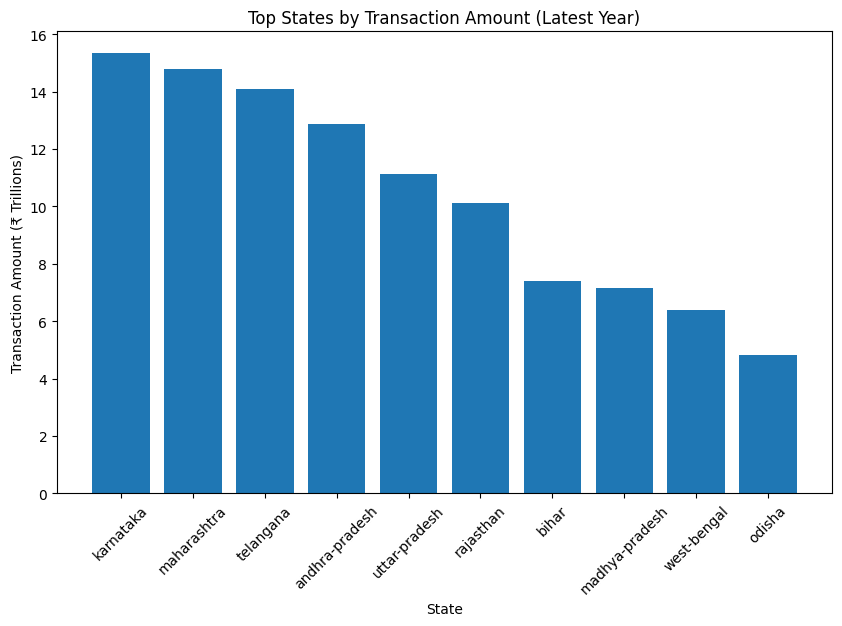

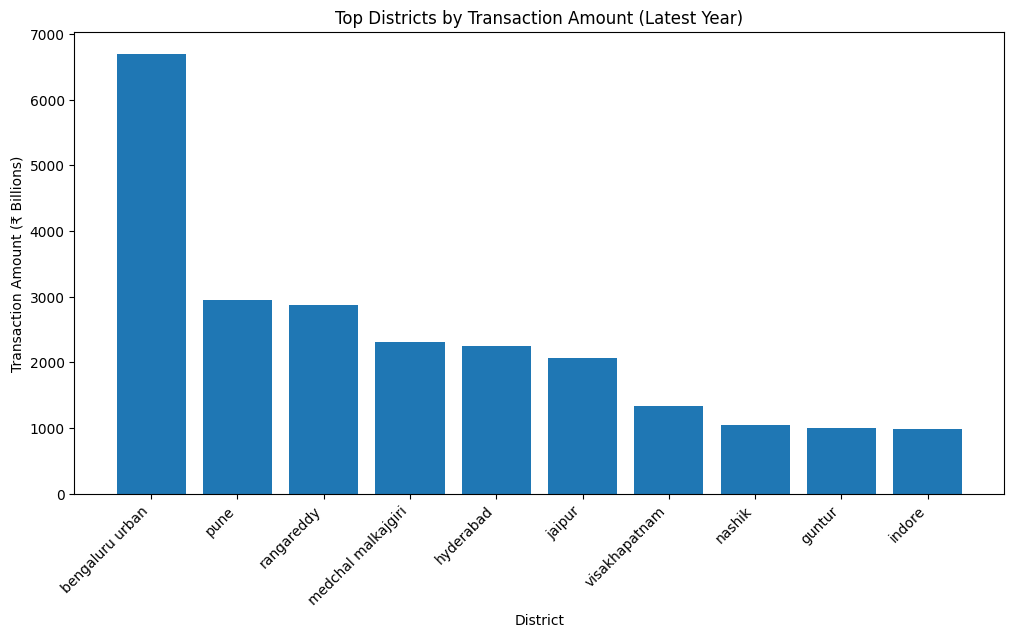

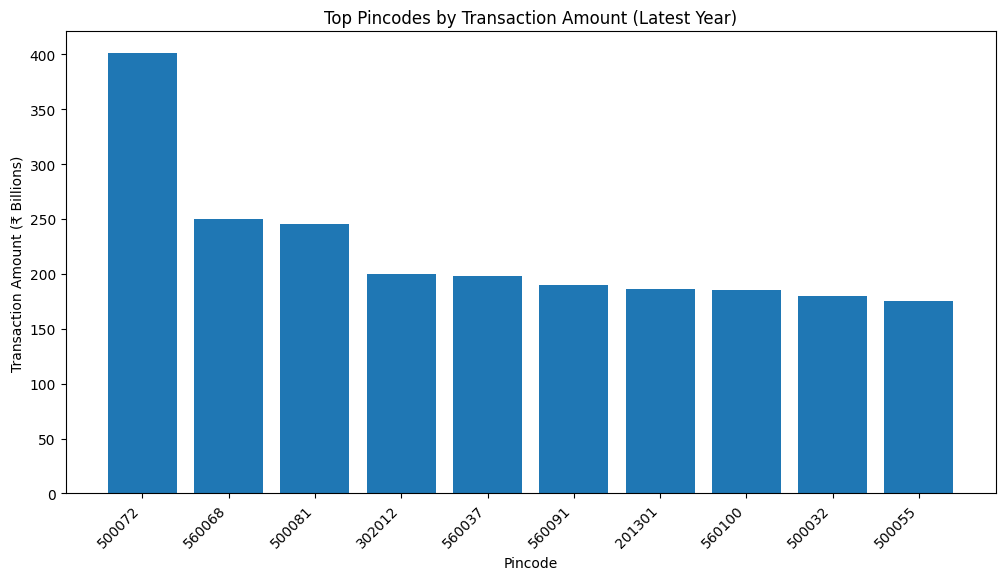

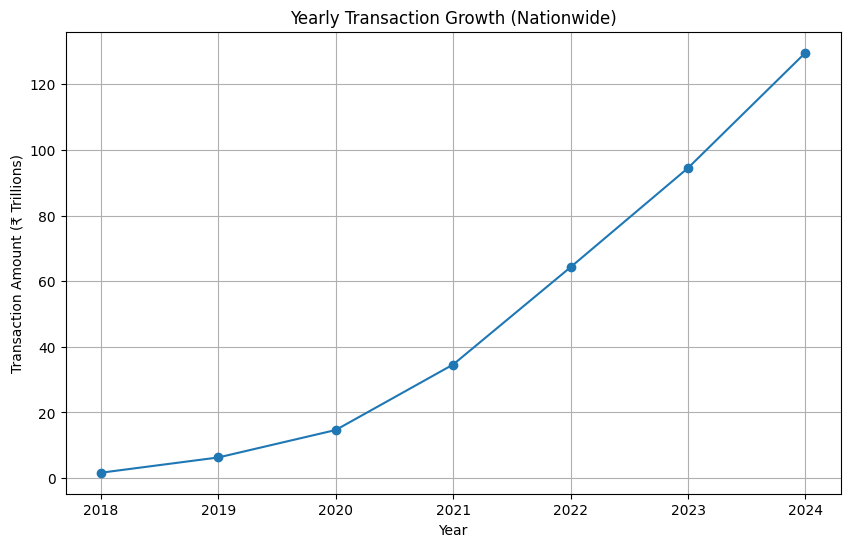

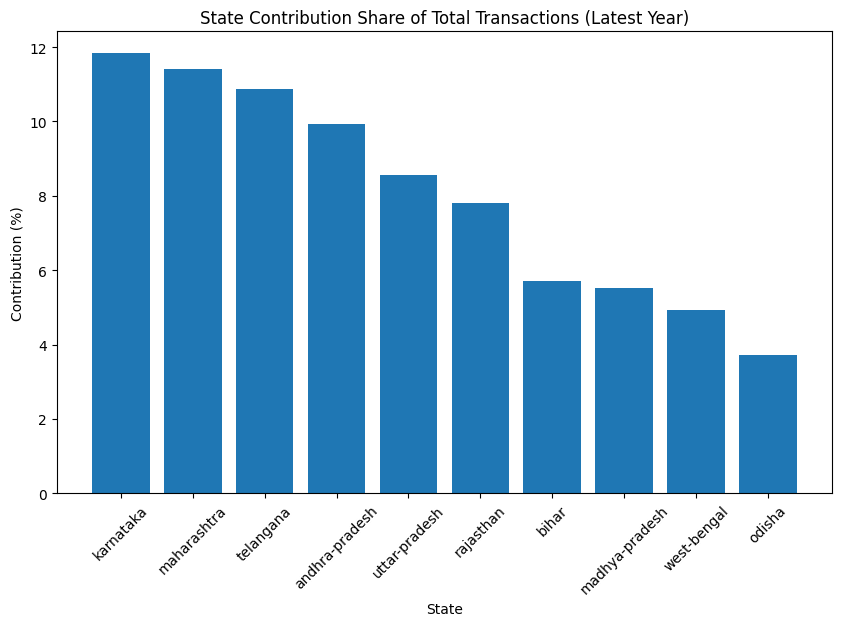

In [72]:
import matplotlib.pyplot as plt

# 1. Top States by Transaction Amount (Latest Year)
df1 = results["Top States by Transaction Amount (Latest Year)"]
plt.figure(figsize=(10,6))
plt.bar(df1["state"], df1["total_amount"]/1e12)  # convert to Trillions
plt.title("Top States by Transaction Amount (Latest Year)")
plt.xlabel("State")
plt.ylabel("Transaction Amount (₹ Trillions)")
plt.xticks(rotation=45)
plt.show()

# 2. Top Districts by Transaction Amount (Latest Year)
df2 = results["Top Districts by Transaction Amount (Latest Year)"]
plt.figure(figsize=(12,6))
plt.bar(df2["district"], df2["total_amount"]/1e9)  # convert to Billions
plt.title("Top Districts by Transaction Amount (Latest Year)")
plt.xlabel("District")
plt.ylabel("Transaction Amount (₹ Billions)")
plt.xticks(rotation=45, ha="right")
plt.show()

# 3. Top Pincodes by Transaction Amount (Latest Year)
df3 = results["Top Pincodes by Transaction Amount (Latest Year)"]
plt.figure(figsize=(12,6))
plt.bar(df3["pincode"], df3["total_amount"]/1e9)  # convert to Billions
plt.title("Top Pincodes by Transaction Amount (Latest Year)")
plt.xlabel("Pincode")
plt.ylabel("Transaction Amount (₹ Billions)")
plt.xticks(rotation=45, ha="right")
plt.show()

# 4. Yearly Transaction Growth
df4 = results["Yearly Transaction Growth"]
plt.figure(figsize=(10,6))
plt.plot(df4["year"], df4["yearly_amount"]/1e12, marker="o")
plt.title("Yearly Transaction Growth (Nationwide)")
plt.xlabel("Year")
plt.ylabel("Transaction Amount (₹ Trillions)")
plt.grid(True)
plt.show()

# 5. State Contribution Share (Latest Year)
df5 = results["State Contribution Share (Latest Year)"]
plt.figure(figsize=(10,6))
plt.bar(df5["state"], df5["contribution_percent"])
plt.title("State Contribution Share of Total Transactions (Latest Year)")
plt.xlabel("State")
plt.ylabel("Contribution (%)")
plt.xticks(rotation=45)
plt.show()


In [73]:
!pip install streamlit


In [74]:
def normalize_state_names(df, column="state"):
    mapping = {
        "andaman-&-nicobar-islands": "Andaman and Nicobar",
        "dadara-&-nagar-havelli-&-daman-&-diu": "Dadra and Nagar Haveli and Daman and Diu",
        "jammu-&-kashmir": "Jammu and Kashmir",
        "delhi": "Delhi",
        "odisha": "Odisha",
        "pondicherry": "Puducherry"
    }
    df[column] = df[column].str.replace("-", " ").str.title().replace(mapping)
    return df


In [75]:
import streamlit as st
import sqlite3
import pandas as pd
import plotly.express as px
import requests

# -------------------------------
# DB Path & Connection
# -------------------------------
DB_PATH = "/content/project_files/phonepe_pulse.db"

@st.cache_data
def load_data(query):
    conn = sqlite3.connect(DB_PATH)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# -------------------------------
# Load India GeoJSON from gist
# -------------------------------
geojson_url = "https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson"
india_geo = requests.get(geojson_url).json()

# -------------------------------
# Helper: Normalize state names
# -------------------------------
def normalize_state_names(df, column="state"):
    # Convert DB states like 'andhra-pradesh' → 'Andhra Pradesh'
    df[column] = df[column].str.replace("-", " ").str.title()
    # Manual corrections if needed
    mapping = {
        "Andaman & Nicobar Islands": "Andaman & Nicobar",
        "Nct Of Delhi": "Delhi",
        "Jammu & Kashmir": "Jammu And Kashmir",
        "Dadra & Nagar Havelli & Daman & Diu": "Dadra And Nagar Haveli And Daman And Diu"
    }
    df[column] = df[column].replace(mapping)
    return df

# -------------------------------
# Helper: Download button
# -------------------------------
def add_download_button(df, label):
    csv = df.to_csv(index=False).encode('utf-8')
    st.download_button(
        label=f"⬇️ Download {label} as CSV",
        data=csv,
        file_name=f"{label.replace(' ','_').lower()}.csv",
        mime="text/csv"
    )

# -------------------------------
# Streamlit Layout
# -------------------------------
st.set_page_config(page_title="PhonePe Pulse Project", layout="wide")

st.title("📊 PhonePe Pulse Project")
st.markdown("An interactive dashboard inspired by **PhonePe Pulse** using our SQLite DB.")

# Sidebar Filters
st.sidebar.header("🔎 Explore Data")
data_type = st.sidebar.radio("Select Data Type", ["Transactions", "Insurance"])
year = st.sidebar.selectbox("Select Year", [2018, 2019, 2020, 2021, 2022, 2023, 2024])
quarter = st.sidebar.selectbox("Select Quarter", [1, 2, 3, 4])

# -------------------------------
# Home Page Map + Bar
# -------------------------------
if data_type == "Transactions":
    query = f"""
    SELECT state, SUM(amount) as total_amount
    FROM aggregated_transaction
    WHERE year = {year} AND quarter = {quarter}
    GROUP BY state
    ORDER BY total_amount DESC;
    """
    df = load_data(query)
    st.subheader(f"💰 Transactions - {year} Q{quarter}")

    if not df.empty:
        df = normalize_state_names(df, "state")

        fig_map = px.choropleth(
            df,
            geojson=india_geo,
            featureidkey="properties.ST_NM",  # ✅ matches gist
            locations="state",
            color="total_amount",
            color_continuous_scale="Blues",
            title="Transaction Amount by State"
        )
        fig_map.update_geos(fitbounds="locations", visible=False)
        st.plotly_chart(fig_map, use_container_width=True)

        fig_bar = px.bar(df, x="state", y="total_amount",
                         title="Transaction Amount by State",
                         labels={"total_amount": "₹ Amount"}, text_auto=".2s")
        st.plotly_chart(fig_bar, use_container_width=True)
        add_download_button(df, "Transaction_Data")

else:
    query = f"""
    SELECT state, SUM(amount) as total_amount
    FROM aggregated_insurance
    WHERE year = {year} AND quarter = {quarter}
    GROUP BY state
    ORDER BY total_amount DESC;
    """
    df = load_data(query)
    st.subheader(f"🛡️ Insurance - {year} Q{quarter}")

    if not df.empty:
        df = normalize_state_names(df, "state")

        fig_map = px.choropleth(
            df,
            geojson=india_geo,
            featureidkey="properties.ST_NM",  # ✅ matches gist
            locations="state",
            color="total_amount",
            color_continuous_scale="Greens",
            title="Insurance Amount by State"
        )
        fig_map.update_geos(fitbounds="locations", visible=False)
        st.plotly_chart(fig_map, use_container_width=True)

        fig_bar = px.bar(df, x="state", y="total_amount",
                         title="Insurance Amount by State",
                         labels={"total_amount": "₹ Amount"}, text_auto=".2s")
        st.plotly_chart(fig_bar, use_container_width=True)
        add_download_button(df, "Insurance_Data")

# -------------------------------
# Business Case Studies (Tabs)
# -------------------------------
st.markdown("## 📂 Business Case Studies")

tab1, tab2, tab3, tab4, tab5 = st.tabs([
    "Case Study 1: Transaction Dynamics",
    "Case Study 2: Device Dominance",
    "Case Study 3: Insurance Growth",
    "Case Study 4: User Engagement",
    "Case Study 5: Geo Transactions"
])

# CASE 1
with tab1:
    st.subheader("Case Study 1: Decoding Transaction Dynamics")
    query = """
    SELECT year, SUM(amount) AS yearly_amount
    FROM aggregated_transaction
    GROUP BY year
    ORDER BY year;
    """
    df = load_data(query)
    fig = px.line(df, x="year", y="yearly_amount", markers=True,
                  title="Yearly Transaction Growth")
    st.plotly_chart(fig, use_container_width=True)
    add_download_button(df, "Case1_Yearly_Transactions")

# CASE 2
with tab2:
    st.subheader("Case Study 2: Device Dominance and User Engagement")
    query = """
    SELECT brand, SUM(count) AS total_users
    FROM aggregated_user
    WHERE brand != 'TOTAL'
    GROUP BY brand
    ORDER BY total_users DESC
    LIMIT 10;
    """
    df = load_data(query)
    fig = px.bar(df, x="brand", y="total_users",
                 title="Top Device Brands by Users", text_auto=".2s")
    st.plotly_chart(fig, use_container_width=True)
    add_download_button(df, "Case2_Device_Dominance")

# CASE 3
with tab3:
    st.subheader("Case Study 3: Insurance Penetration & Growth")
    query = """
    SELECT year, SUM(amount) AS yearly_insurance_amount
    FROM aggregated_insurance
    GROUP BY year
    ORDER BY year;
    """
    df = load_data(query)
    fig = px.line(df, x="year", y="yearly_insurance_amount", markers=True,
                  title="Yearly Insurance Growth")
    st.plotly_chart(fig, use_container_width=True)
    add_download_button(df, "Case3_Insurance_Growth")

# CASE 4
with tab4:
    st.subheader("Case Study 4: User Engagement and Growth")
    query = """
    SELECT year, SUM(count) AS yearly_users
    FROM aggregated_user
    WHERE brand = 'TOTAL'
    GROUP BY year
    ORDER BY year;
    """
    df = load_data(query)
    fig = px.line(df, x="year", y="yearly_users", markers=True,
                  title="Yearly Registered Users")
    st.plotly_chart(fig, use_container_width=True)
    add_download_button(df, "Case4_User_Engagement")

# CASE 5
with tab5:
    st.subheader("Case Study 5: Transaction Analysis Across Geo")
    query = """
    SELECT state, SUM(amount) AS total_amount
    FROM aggregated_transaction
    WHERE year = (SELECT MAX(year) FROM aggregated_transaction)
    GROUP BY state
    ORDER BY total_amount DESC
    LIMIT 10;
    """
    df = load_data(query)
    df = normalize_state_names(df, "state")
    fig = px.bar(df, x="state", y="total_amount",
                 title="Top States by Transaction Amount (Latest Year)", text_auto=".2s")
    st.plotly_chart(fig, use_container_width=True)
    add_download_button(df, "Case5_Geo_Transactions")


2025-10-06 18:40:15.366 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-06 18:40:15.753 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-06 18:40:15.754 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-06 18:40:15.877 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-06 18:40:15.878 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-06 18:40:15.879 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-06 18:40:15.881 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runnin

In [76]:
import streamlit as st
import sqlite3
import pandas as pd
import plotly.express as px
import requests
from pyngrok import ngrok
import time

# -------------------------------
# NGROK SETUP
# -------------------------------
NGROK_TOKEN = "33W8aNQvOwRd7wbQB2rRLIy1tod_6oZzTz9tBRRzehoJEJVJd"
ngrok.set_auth_token(NGROK_TOKEN)

# -------------------------------
# DATABASE PATH
# -------------------------------
DB_PATH = "/content/project_files/phonepe_pulse.db"

# -------------------------------
# Cached DB Loader
# -------------------------------
@st.cache_data
def load_data(query):
    conn = sqlite3.connect(DB_PATH)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# -------------------------------
# GeoJSON for India Map
# -------------------------------
geojson_url = "https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson"
india_geo = requests.get(geojson_url).json()

# -------------------------------
# Helper Functions
# -------------------------------
def normalize_state_names(df, column="state"):
    df[column] = df[column].str.replace("-", " ").str.title()
    mapping = {
        "Andaman & Nicobar Islands": "Andaman & Nicobar",
        "Nct Of Delhi": "Delhi",
        "Jammu & Kashmir": "Jammu And Kashmir",
        "Dadra & Nagar Havelli & Daman & Diu": "Dadra And Nagar Haveli And Daman And Diu"
    }
    df[column] = df[column].replace(mapping)
    return df

def add_download_button(df, label):
    csv = df.to_csv(index=False).encode('utf-8')
    st.download_button(
        label=f"Download {label} (CSV)",
        data=csv,
        file_name=f"{label.replace(' ','_').lower()}.csv",
        mime="text/csv"
    )

# -------------------------------
# PAGE CONFIG + STYLING
# -------------------------------
st.set_page_config(page_title="PhonePe Pulse Analytics", layout="wide")

# --- Custom Styling ---
st.markdown("""
    <style>
        html, body, [class*="css"] {
            font-family: 'Inter', sans-serif;
            color: #1c1c1e;
        }
        [data-testid="stSidebar"] {
            background-color: #1f2937;
            color: #f5f5f7;
        }
        [data-testid="stSidebar"] h1, [data-testid="stSidebar"] h2, [data-testid="stSidebar"] h3, [data-testid="stSidebar"] label, [data-testid="stSidebar"] p {
            color: #f5f5f7 !important;
        }
        h1 { font-size: 28px !important; color: #111827; margin-bottom: 0.5em; }
        .metric-dark {
            background-color: #1f2937;
            padding: 20px;
            border-radius: 10px;
            color: white !important;
            text-align: center;
        }
    </style>
""", unsafe_allow_html=True)

# -------------------------------
# SIDEBAR NAVIGATION
# -------------------------------
st.sidebar.title("📈 Dashboard Navigation")
page = st.sidebar.radio("Select Section", ["Overview", "Case Studies"])

# -------------------------------
# HOME PAGE (Overview)
# -------------------------------
if page == "Overview":
    st.title("PhonePe Pulse Analytics Dashboard")
    st.caption("A professional insights dashboard for transaction and insurance analytics across India.")
    st.markdown("---")

    data_type = st.sidebar.radio("Data Type", ["Transactions", "Insurance"])
    year = st.sidebar.selectbox("Year", [2018, 2019, 2020, 2021, 2022, 2023, 2024])
    quarter = st.sidebar.selectbox("Quarter", [1, 2, 3, 4])

    if data_type == "Transactions":
        query = f"""
        SELECT state, SUM(amount) as total_amount
        FROM aggregated_transaction
        WHERE year = {year} AND quarter = {quarter}
        GROUP BY state
        ORDER BY total_amount DESC;
        """
        df = load_data(query)
        st.subheader(f"Transactions Overview — {year} Q{quarter}")

        if not df.empty:
            df = normalize_state_names(df)
            col1, col2 = st.columns([2, 1])
            with col1:
                fig_map = px.choropleth(
                    df,
                    geojson=india_geo,
                    featureidkey="properties.ST_NM",
                    locations="state",
                    color="total_amount",
                    color_continuous_scale="blues",
                    title="State-wise Transaction Values"
                )
                fig_map.update_geos(fitbounds="locations", visible=False)
                st.plotly_chart(fig_map, use_container_width=True)

            with col2:
                st.markdown("<div class='metric-dark'>", unsafe_allow_html=True)
                st.markdown(f"<h4>Top Performing State</h4><h2>{df.iloc[0]['state']}</h2>", unsafe_allow_html=True)
                st.markdown(f"<h4>Total Value (₹)</h4><h2>{df['total_amount'].sum():,.0f}</h2>", unsafe_allow_html=True)
                st.markdown("</div>", unsafe_allow_html=True)

            st.markdown("---")
            fig_bar = px.bar(df, x="state", y="total_amount", text_auto=".2s", color="total_amount",
                             title="Transaction Value by State")
            st.plotly_chart(fig_bar, use_container_width=True)
            add_download_button(df, "Transaction_Data")

    else:
        query = f"""
        SELECT state, SUM(amount) as total_amount
        FROM aggregated_insurance
        WHERE year = {year} AND quarter = {quarter}
        GROUP BY state
        ORDER BY total_amount DESC;
        """
        df = load_data(query)
        st.subheader(f"Insurance Overview — {year} Q{quarter}")

        if not df.empty:
            df = normalize_state_names(df)
            col1, col2 = st.columns([2, 1])
            with col1:
                fig_map = px.choropleth(
                    df,
                    geojson=india_geo,
                    featureidkey="properties.ST_NM",
                    locations="state",
                    color="total_amount",
                    color_continuous_scale="greens",
                    title="State-wise Insurance Distribution"
                )
                fig_map.update_geos(fitbounds="locations", visible=False)
                st.plotly_chart(fig_map, use_container_width=True)
            with col2:
                st.markdown("<div class='metric-dark'>", unsafe_allow_html=True)
                st.markdown(f"<h4>Top State (Insurance)</h4><h2>{df.iloc[0]['state']}</h2>", unsafe_allow_html=True)
                st.markdown(f"<h4>Total Value (₹)</h4><h2>{df['total_amount'].sum():,.0f}</h2>", unsafe_allow_html=True)
                st.markdown("</div>", unsafe_allow_html=True)

            st.markdown("---")
            fig_bar = px.bar(df, x="state", y="total_amount", text_auto=".2s", color="total_amount",
                             title="Insurance Amount by State")
            st.plotly_chart(fig_bar, use_container_width=True)
            add_download_button(df, "Insurance_Data")

# -------------------------------
# CASE STUDIES PAGE (All 5)
# -------------------------------
elif page == "Case Studies":
    st.title("Analytical Case Studies")
    st.caption("In-depth exploration of PhonePe Pulse data across multiple analytical perspectives.")
    st.markdown("---")

    case_selected = st.selectbox(
        "Select Case Study",
        [
            "Case Study 1: Transaction Dynamics",
            "Case Study 2: Device Dominance & User Engagement",
            "Case Study 3: Insurance Growth & Penetration",
            "Case Study 4: User Growth & Engagement",
            "Case Study 5: Geo-based Transaction Insights"
        ]
    )

    # ✅ Case Study 1–5 logic modularized
    if "Case Study 1" in case_selected:
        st.subheader("Case Study 1 — Transaction Dynamics")
        tabs = st.tabs(["Q1", "Q2", "Q3", "Q4", "Q5"])
        with tabs[0]:
            df = load_data("SELECT state, SUM(amount) AS total_amount FROM aggregated_transaction GROUP BY state ORDER BY total_amount DESC LIMIT 10;")
            fig = px.bar(df, x="state", y="total_amount", text_auto=".2s")
            st.plotly_chart(fig)
        with tabs[1]:
            df = load_data("SELECT year, SUM(amount) AS yearly_amount FROM aggregated_transaction GROUP BY year;")
            fig = px.line(df, x="year", y="yearly_amount", markers=True)
            st.plotly_chart(fig)
        with tabs[2]:
            df = load_data("SELECT year, quarter, SUM(amount) AS total_amount FROM aggregated_transaction WHERE state='karnataka' GROUP BY year, quarter;")
            fig = px.line(df, x="quarter", y="total_amount", color="year", markers=True)
            st.plotly_chart(fig)
        with tabs[3]:
            df = load_data("SELECT category, SUM(amount) AS total_amount FROM aggregated_transaction GROUP BY category;")
            fig = px.bar(df, x="category", y="total_amount", text_auto=".2s")
            st.plotly_chart(fig)
        with tabs[4]:
            df = load_data("SELECT category, SUM(amount) AS total_amount FROM aggregated_transaction WHERE year=2023 GROUP BY category;")
            fig = px.pie(df, names="category", values="total_amount")
            st.plotly_chart(fig)

    elif "Case Study 2" in case_selected:
        st.subheader("Case Study 2 — Device Dominance & User Engagement")
        tabs = st.tabs(["Q1", "Q2", "Q3", "Q4", "Q5"])
        with tabs[0]:
            df = load_data("SELECT brand, SUM(count) AS total_users FROM aggregated_user WHERE brand!='TOTAL' GROUP BY brand ORDER BY total_users DESC LIMIT 10;")
            fig = px.bar(df, x="brand", y="total_users", text_auto=".2s")
            st.plotly_chart(fig)
        with tabs[1]:
            df = load_data("SELECT year, SUM(percentage) AS total_app_opens FROM aggregated_user WHERE brand='TOTAL' GROUP BY year;")
            fig = px.line(df, x="year", y="total_app_opens", markers=True)
            st.plotly_chart(fig)
        with tabs[2]:
            df = load_data("SELECT state, brand, SUM(count) AS total_users FROM aggregated_user WHERE year=(SELECT MAX(year) FROM aggregated_user) AND brand!='TOTAL' GROUP BY state, brand;")
            fig = px.bar(df, x="brand", y="total_users", color="state")
            st.plotly_chart(fig)
        with tabs[3]:
            df = load_data("SELECT state, SUM(count) AS total_users FROM aggregated_user WHERE brand='TOTAL' GROUP BY state ORDER BY total_users DESC LIMIT 5;")
            fig = px.bar(df, x="state", y="total_users")
            st.plotly_chart(fig)
        with tabs[4]:
            df = load_data("SELECT year, quarter, SUM(count) AS xiaomi_users FROM aggregated_user WHERE brand='Xiaomi' GROUP BY year, quarter;")
            fig = px.line(df, x="quarter", y="xiaomi_users", color="year", markers=True)
            st.plotly_chart(fig)

    elif "Case Study 3" in case_selected:
        st.subheader("Case Study 3 — Insurance Growth & Penetration")
        tabs = st.tabs(["Q1", "Q2", "Q3", "Q4", "Q5"])
        with tabs[0]:
            df = load_data("SELECT state, SUM(amount) AS total_insurance_amount FROM aggregated_insurance GROUP BY state ORDER BY total_insurance_amount DESC LIMIT 10;")
            fig = px.bar(df, x="state", y="total_insurance_amount")
            st.plotly_chart(fig)
        with tabs[1]:
            df = load_data("SELECT year, SUM(amount) AS yearly_insurance_amount FROM aggregated_insurance GROUP BY year;")
            fig = px.line(df, x="year", y="yearly_insurance_amount", markers=True)
            st.plotly_chart(fig)
        with tabs[2]:
            df = load_data("SELECT year, quarter, SUM(amount) AS quarterly_amount FROM aggregated_insurance WHERE state='karnataka' GROUP BY year, quarter;")
            fig = px.line(df, x="quarter", y="quarterly_amount", color="year")
            st.plotly_chart(fig)
        with tabs[3]:
            df = load_data("SELECT state, SUM(amount) AS total_amount FROM aggregated_insurance GROUP BY state ORDER BY total_amount DESC LIMIT 5;")
            fig = px.bar(df, x="state", y="total_amount")
            st.plotly_chart(fig)
        with tabs[4]:
            df = load_data("""
                SELECT t.state, ROUND(SUM(i.amount)/SUM(t.amount)*100,2) AS penetration_percent
                FROM aggregated_transaction t
                JOIN aggregated_insurance i ON t.state=i.state
                GROUP BY t.state
                ORDER BY penetration_percent DESC LIMIT 10;
            """)
            fig = px.bar(df, x="state", y="penetration_percent", color="penetration_percent")
            st.plotly_chart(fig)

    elif "Case Study 4" in case_selected:
        st.subheader("Case Study 4 — User Growth & Engagement")
        tabs = st.tabs(["Q1", "Q2", "Q3", "Q4", "Q5"])
        with tabs[0]:
            df = load_data("SELECT state, SUM(count) AS total_users FROM aggregated_user WHERE brand='TOTAL' AND year=(SELECT MAX(year) FROM aggregated_user) GROUP BY state ORDER BY total_users DESC LIMIT 10;")
            fig = px.bar(df, x="state", y="total_users")
            st.plotly_chart(fig)
        with tabs[1]:
            df = load_data("SELECT year, SUM(count) AS yearly_users FROM aggregated_user WHERE brand='TOTAL' GROUP BY year;")
            fig = px.line(df, x="year", y="yearly_users", markers=True)
            st.plotly_chart(fig)
        with tabs[2]:
            df = load_data("SELECT year, quarter, SUM(percentage) AS total_app_opens FROM aggregated_user WHERE brand='TOTAL' AND state='karnataka' GROUP BY year, quarter;")
            fig = px.line(df, x="quarter", y="total_app_opens", color="year", markers=True)
            st.plotly_chart(fig)
        with tabs[3]:
            df = load_data("SELECT district, SUM(registeredUsers) AS total_users FROM map_user WHERE year=(SELECT MAX(year) FROM map_user) GROUP BY district ORDER BY total_users DESC LIMIT 10;")
            fig = px.bar(df, x="district", y="total_users")
            st.plotly_chart(fig)
        with tabs[4]:
            df = load_data("SELECT state, SUM(count) AS total_users, SUM(percentage) AS total_app_opens, ROUND(SUM(percentage)*1.0/SUM(count),2) AS engagement_ratio FROM aggregated_user WHERE brand='TOTAL' GROUP BY state ORDER BY engagement_ratio DESC LIMIT 10;")
            fig = px.bar(df, x="state", y="engagement_ratio")
            st.plotly_chart(fig)

    elif "Case Study 5" in case_selected:
        st.subheader("Case Study 5 — Geo-based Transaction Insights")
        tabs = st.tabs(["Q1", "Q2", "Q3", "Q4", "Q5"])
        with tabs[0]:
            df = load_data("SELECT state, SUM(amount) AS total_amount FROM aggregated_transaction WHERE year=(SELECT MAX(year) FROM aggregated_transaction) GROUP BY state ORDER BY total_amount DESC LIMIT 10;")
            fig = px.bar(df, x="state", y="total_amount")
            st.plotly_chart(fig)
        with tabs[1]:
            df = load_data("SELECT entityName AS district, SUM(amount) AS total_amount FROM top_transaction WHERE level='districts' GROUP BY entityName ORDER BY total_amount DESC LIMIT 10;")
            fig = px.bar(df, x="district", y="total_amount")
            st.plotly_chart(fig)
        with tabs[2]:
            df = load_data("SELECT entityName AS pincode, SUM(amount) AS total_amount FROM top_transaction WHERE level='pincodes' GROUP BY entityName ORDER BY total_amount DESC LIMIT 10;")
            fig = px.bar(df, x="pincode", y="total_amount")
            st.plotly_chart(fig)
        with tabs[3]:
            df = load_data("SELECT year, SUM(amount) AS yearly_amount FROM aggregated_transaction GROUP BY year;")
            fig = px.line(df, x="year", y="yearly_amount", markers=True)
            st.plotly_chart(fig)
        with tabs[4]:
            df = load_data("""
                WITH total AS (
                    SELECT SUM(amount) AS national_total FROM aggregated_transaction WHERE year=(SELECT MAX(year) FROM aggregated_transaction)
                )
                SELECT state, SUM(amount) AS state_total, ROUND(SUM(amount)*100.0/(SELECT national_total FROM total),2) AS contribution_percent
                FROM aggregated_transaction WHERE year=(SELECT MAX(year) FROM aggregated_transaction)
                GROUP BY state ORDER BY state_total DESC LIMIT 10;
            """)
            fig = px.bar(df, x="state", y="contribution_percent", color="contribution_percent")
            st.plotly_chart(fig)


2025-10-06 18:40:17.074 No runtime found, using MemoryCacheStorageManager
2025-10-06 18:40:17.287 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-06 18:40:17.288 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-06 18:40:17.289 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-06 18:40:17.290 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-06 18:40:17.290 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-06 18:40:17.291 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-06 18:40:17.292 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-06 18:40:17.293 Thread 'MainThread':

In [77]:
!pip install pyngrok


In [78]:
from pyngrok import ngrok

# paste your token here
!ngrok config add-authtoken 33W8aNQvOwRd7wbQB2rRLIy1tod_6oZzTz9tBRRzehoJEJVJd


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [79]:
import os
path="/content/pulse/data/aggregated/transaction/country/india/state/"
Agg_state_list=os.listdir(path)
Agg_state_list

['arunachal-pradesh',
 'west-bengal',
 'bihar',
 'puducherry',
 'assam',
 'telangana',
 'tamil-nadu',
 'odisha',
 'uttar-pradesh',
 'delhi',
 'chandigarh',
 'haryana',
 'karnataka',
 'jammu-&-kashmir',
 'nagaland',
 'uttarakhand',
 'punjab',
 'andhra-pradesh',
 'maharashtra',
 'goa',
 'chhattisgarh',
 'tripura',
 'andaman-&-nicobar-islands',
 'meghalaya',
 'sikkim',
 'himachal-pradesh',
 'manipur',
 'gujarat',
 'mizoram',
 'dadra-&-nagar-haveli-&-daman-&-diu',
 'kerala',
 'jharkhand',
 'lakshadweep',
 'madhya-pradesh',
 'ladakh',
 'rajasthan']

In [80]:
#Once created the clone of GIT-HUB repository then,
#Required libraries for the program

import pandas as pd
import json
import os

#This is to direct the path to get the data as states

path="/content/pulse/data/aggregated/transaction/country/india/state/"
Agg_state_list=os.listdir(path)
Agg_state_list
#Agg_state_list--> to get the list of states in India

#<------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------>#

#This is to extract the data's to create a dataframe

clm={'State':[], 'Year':[],'Quater':[],'Transacion_type':[], 'Transacion_count':[], 'Transacion_amount':[]}

for i in Agg_state_list:
    p_i=path+i+"/"
    Agg_yr=os.listdir(p_i)
    for j in Agg_yr:
        p_j=p_i+j+"/"
        Agg_yr_list=os.listdir(p_j)
        for k in Agg_yr_list:
            p_k=p_j+k
            Data=open(p_k,'r')
            D=json.load(Data)
            for z in D['data']['transactionData']:
              Name=z['name']
              count=z['paymentInstruments'][0]['count']
              amount=z['paymentInstruments'][0]['amount']
              clm['Transacion_type'].append(Name)
              clm['Transacion_count'].append(count)
              clm['Transacion_amount'].append(amount)
              clm['State'].append(i)
              clm['Year'].append(j)
              clm['Quater'].append(int(k.strip('.json')))
#Succesfully created a dataframe
Agg_Trans=pd.DataFrame(clm)


In [81]:
len(Agg_Trans['State'].unique())

36

In [82]:
import pandas as pd
import plotly.express as px

df = pd.read_csv("https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/active_cases_2020-07-17_0800.csv")

fig = px.choropleth(
    df,
    geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
    featureidkey='properties.ST_NM',
    locations='state',
    color='active cases',
    color_continuous_scale='Reds'
)

fig.update_geos(fitbounds="locations", visible=False)

fig.show()

In [83]:
df

,state,active cases
0,Andaman & Nicobar,47
1,Andhra Pradesh,18159
2,Arunachal Pradesh,387
3,Assam,6818
4,Bihar,7549
5,Chandigarh,164
6,Chhattisgarh,1260
7,Dadra and Nagar Haveli and Daman and Diu,179
8,Delhi,17407
9,Goa,1272


In [84]:
!pip install streamlit pyngrok -q
!pkill streamlit || echo "No process"
from pyngrok import ngrok
public_url = ngrok.connect(8501).public_url
print(f"🔗 Dashboard URL: {public_url}")
!streamlit run /content/project_files/app.py --server.port 8501 > /dev/null 2>&1 &
time.sleep(5)
print("✅ Streamlit dashboard running successfully.")



No process
🔗 Dashboard URL: https://uninfectiously-unversatile-leigha.ngrok-free.dev


✅ Streamlit dashboard running successfully.
